# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 45kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

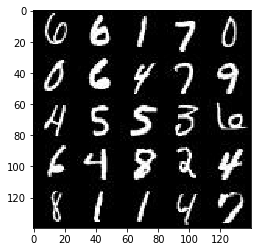

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

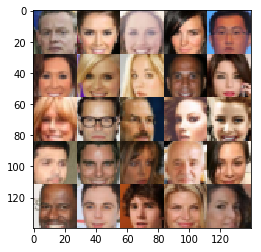

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        h1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        h1 = tf.maximum(0.2*h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides = 1, padding ='same')
        h2 = tf.layers.batch_normalization(h2, training = True)
        h2 = tf.maximum(0.2*h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides = 2, padding = 'same')
        h3 = tf.layers.batch_normalization(h3, training = True)
        h3 = tf.maximum(0.2*h3, h3)
        
        flatten = tf.reshape(h3, (-1, 7*7*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):    
        x1 = tf.layers.dense(z, 7*7*256, activation= None)
        
        h2 = tf.reshape(x1, (-1, 7, 7, 256))
        h2 = tf.layers.batch_normalization(h2, training = is_train)
        h2 = tf.maximum(0.2*h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides = 1, padding = 'same')
        h3 = tf.layers.batch_normalization(h3, training = is_train)
        h3 = tf.maximum(0.2*h3, h3)
        
        h4 = tf.layers.conv2d_transpose(h3, 64, 5, strides = 2, padding = 'same')
        h4 = tf.layers.batch_normalization(h4, training = is_train)
        h4 = tf.maximum(0.2*h4, h4)
        
        logits = tf.layers.conv2d_transpose(h4, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_fake = generator(input_z, out_channel_dim, is_train = True)
    out_real, logits_real = discriminator(input_real)
    out_fake, logits_fake = discriminator(input_fake, reuse = True)

    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.ones_like(out_fake)))

    loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_real, labels = tf.ones_like(out_real)* (1 - 0.2)))
    loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.zeros_like(out_fake)))
    
    total_loss = loss_real + loss_fake

    return total_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        
        d_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_fake, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    dloss, gloss = model_loss(input_real, input_fake, data_shape[3])
    d_train_opt, g_train_opt = model_opt(dloss, gloss, learning_rate, beta1)

    print_every = 10
    show_every = 5
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size= (batch_size, z_dim))
                batch_images = batch_images * 2.0
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_fake: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    d_loss = dloss.eval({input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                    g_loss = gloss.eval({input_fake: batch_z})
                    print("Epoch {}/{}....".format(epoch_i + 1, epoch_count),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}....".format(d_loss),
                          "Generator Loss: {:.4f}".format(g_loss))
                
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_fake, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2.... Batch 10... Discriminator Loss: 4.6695.... Generator Loss: 0.5537
Epoch 1/2.... Batch 20... Discriminator Loss: 1.3937.... Generator Loss: 2.8597
Epoch 1/2.... Batch 30... Discriminator Loss: 3.2117.... Generator Loss: 0.8488
Epoch 1/2.... Batch 40... Discriminator Loss: 6.9610.... Generator Loss: 12.2152
Epoch 1/2.... Batch 50... Discriminator Loss: 1.4089.... Generator Loss: 11.1915
Epoch 1/2.... Batch 60... Discriminator Loss: 2.9467.... Generator Loss: 0.3446
Epoch 1/2.... Batch 70... Discriminator Loss: 2.3373.... Generator Loss: 0.4149
Epoch 1/2.... Batch 80... Discriminator Loss: 1.6979.... Generator Loss: 4.6057
Epoch 1/2.... Batch 90... Discriminator Loss: 5.4001.... Generator Loss: 7.5667
Epoch 1/2.... Batch 100... Discriminator Loss: 1.7144.... Generator Loss: 0.6453


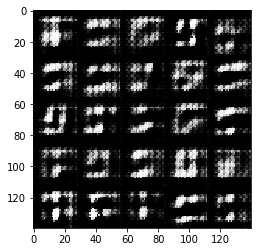

Epoch 1/2.... Batch 110... Discriminator Loss: 1.8240.... Generator Loss: 1.4556
Epoch 1/2.... Batch 120... Discriminator Loss: 0.7905.... Generator Loss: 2.0754
Epoch 1/2.... Batch 130... Discriminator Loss: 1.8632.... Generator Loss: 0.8087
Epoch 1/2.... Batch 140... Discriminator Loss: 1.0494.... Generator Loss: 2.2529
Epoch 1/2.... Batch 150... Discriminator Loss: 0.8602.... Generator Loss: 5.6469
Epoch 1/2.... Batch 160... Discriminator Loss: 0.8204.... Generator Loss: 1.6550
Epoch 1/2.... Batch 170... Discriminator Loss: 0.9785.... Generator Loss: 1.4780
Epoch 1/2.... Batch 180... Discriminator Loss: 0.7471.... Generator Loss: 2.7401
Epoch 1/2.... Batch 190... Discriminator Loss: 0.8134.... Generator Loss: 1.8523
Epoch 1/2.... Batch 200... Discriminator Loss: 1.1127.... Generator Loss: 1.1894


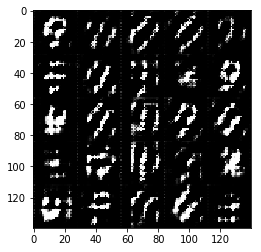

Epoch 1/2.... Batch 210... Discriminator Loss: 0.8587.... Generator Loss: 1.9789
Epoch 1/2.... Batch 220... Discriminator Loss: 1.9409.... Generator Loss: 0.4244
Epoch 1/2.... Batch 230... Discriminator Loss: 1.8057.... Generator Loss: 0.5467
Epoch 1/2.... Batch 240... Discriminator Loss: 1.8010.... Generator Loss: 1.2770
Epoch 1/2.... Batch 250... Discriminator Loss: 0.8416.... Generator Loss: 2.1834
Epoch 1/2.... Batch 260... Discriminator Loss: 1.1348.... Generator Loss: 1.6562
Epoch 1/2.... Batch 270... Discriminator Loss: 1.6922.... Generator Loss: 2.7224
Epoch 1/2.... Batch 280... Discriminator Loss: 3.3899.... Generator Loss: 0.1528
Epoch 1/2.... Batch 290... Discriminator Loss: 1.0907.... Generator Loss: 1.2122
Epoch 1/2.... Batch 300... Discriminator Loss: 1.4252.... Generator Loss: 0.6338


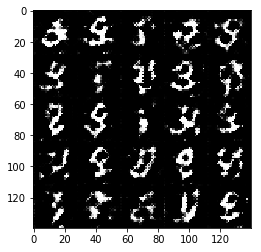

Epoch 1/2.... Batch 310... Discriminator Loss: 1.9172.... Generator Loss: 0.5175
Epoch 1/2.... Batch 320... Discriminator Loss: 1.3971.... Generator Loss: 1.0194
Epoch 1/2.... Batch 330... Discriminator Loss: 1.5326.... Generator Loss: 0.8882
Epoch 1/2.... Batch 340... Discriminator Loss: 0.9937.... Generator Loss: 2.4795
Epoch 1/2.... Batch 350... Discriminator Loss: 1.2819.... Generator Loss: 2.3588
Epoch 1/2.... Batch 360... Discriminator Loss: 1.5197.... Generator Loss: 0.8386
Epoch 1/2.... Batch 370... Discriminator Loss: 1.1737.... Generator Loss: 2.1491
Epoch 1/2.... Batch 380... Discriminator Loss: 1.2217.... Generator Loss: 1.8382
Epoch 1/2.... Batch 390... Discriminator Loss: 1.4074.... Generator Loss: 2.0756
Epoch 1/2.... Batch 400... Discriminator Loss: 1.1303.... Generator Loss: 1.2664


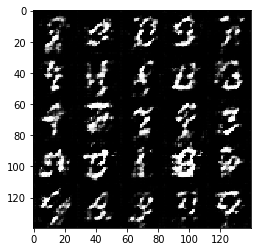

Epoch 1/2.... Batch 410... Discriminator Loss: 1.7479.... Generator Loss: 0.5353
Epoch 1/2.... Batch 420... Discriminator Loss: 1.0310.... Generator Loss: 1.4359
Epoch 1/2.... Batch 430... Discriminator Loss: 1.3597.... Generator Loss: 0.9048
Epoch 1/2.... Batch 440... Discriminator Loss: 1.6704.... Generator Loss: 2.0735
Epoch 1/2.... Batch 450... Discriminator Loss: 1.2397.... Generator Loss: 2.8055
Epoch 1/2.... Batch 460... Discriminator Loss: 1.7526.... Generator Loss: 0.6370
Epoch 1/2.... Batch 470... Discriminator Loss: 1.0728.... Generator Loss: 1.6478
Epoch 1/2.... Batch 480... Discriminator Loss: 1.3759.... Generator Loss: 1.1024
Epoch 1/2.... Batch 490... Discriminator Loss: 1.9721.... Generator Loss: 0.4336
Epoch 1/2.... Batch 500... Discriminator Loss: 0.9261.... Generator Loss: 1.3578


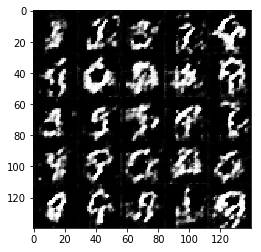

Epoch 1/2.... Batch 510... Discriminator Loss: 1.3746.... Generator Loss: 0.9146
Epoch 1/2.... Batch 520... Discriminator Loss: 1.0003.... Generator Loss: 1.2474
Epoch 1/2.... Batch 530... Discriminator Loss: 1.4540.... Generator Loss: 1.9418
Epoch 1/2.... Batch 540... Discriminator Loss: 1.0946.... Generator Loss: 1.9027
Epoch 1/2.... Batch 550... Discriminator Loss: 1.5282.... Generator Loss: 2.3535
Epoch 1/2.... Batch 560... Discriminator Loss: 1.0440.... Generator Loss: 1.3279
Epoch 1/2.... Batch 570... Discriminator Loss: 1.3374.... Generator Loss: 0.7253
Epoch 1/2.... Batch 580... Discriminator Loss: 0.8394.... Generator Loss: 1.5540
Epoch 1/2.... Batch 590... Discriminator Loss: 1.2959.... Generator Loss: 0.7270
Epoch 1/2.... Batch 600... Discriminator Loss: 1.3701.... Generator Loss: 2.9908


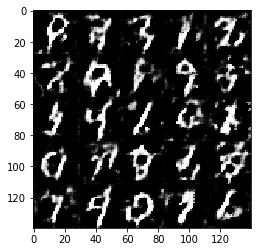

Epoch 1/2.... Batch 610... Discriminator Loss: 1.2925.... Generator Loss: 1.0708
Epoch 1/2.... Batch 620... Discriminator Loss: 1.4287.... Generator Loss: 1.0150
Epoch 1/2.... Batch 630... Discriminator Loss: 1.4528.... Generator Loss: 0.7516
Epoch 1/2.... Batch 640... Discriminator Loss: 1.5451.... Generator Loss: 0.7382
Epoch 1/2.... Batch 650... Discriminator Loss: 1.6972.... Generator Loss: 0.7556
Epoch 1/2.... Batch 660... Discriminator Loss: 1.0228.... Generator Loss: 1.1155
Epoch 1/2.... Batch 670... Discriminator Loss: 1.3680.... Generator Loss: 1.2762
Epoch 1/2.... Batch 680... Discriminator Loss: 0.9843.... Generator Loss: 1.2813
Epoch 1/2.... Batch 690... Discriminator Loss: 1.4538.... Generator Loss: 2.3732
Epoch 1/2.... Batch 700... Discriminator Loss: 1.2675.... Generator Loss: 0.9361


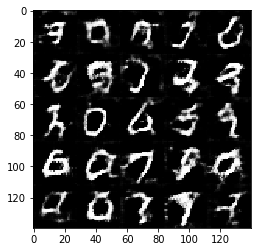

Epoch 1/2.... Batch 710... Discriminator Loss: 1.2926.... Generator Loss: 0.8664
Epoch 1/2.... Batch 720... Discriminator Loss: 1.3584.... Generator Loss: 0.7148
Epoch 1/2.... Batch 730... Discriminator Loss: 1.1879.... Generator Loss: 0.9218
Epoch 1/2.... Batch 740... Discriminator Loss: 2.4332.... Generator Loss: 0.2866
Epoch 1/2.... Batch 750... Discriminator Loss: 1.2770.... Generator Loss: 0.8298
Epoch 1/2.... Batch 760... Discriminator Loss: 1.4318.... Generator Loss: 0.8115
Epoch 1/2.... Batch 770... Discriminator Loss: 1.4796.... Generator Loss: 2.0291
Epoch 1/2.... Batch 780... Discriminator Loss: 1.1177.... Generator Loss: 1.0885
Epoch 1/2.... Batch 790... Discriminator Loss: 1.1890.... Generator Loss: 1.3192
Epoch 1/2.... Batch 800... Discriminator Loss: 1.0911.... Generator Loss: 1.3766


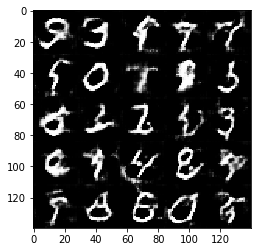

Epoch 1/2.... Batch 810... Discriminator Loss: 1.2909.... Generator Loss: 1.7529
Epoch 1/2.... Batch 820... Discriminator Loss: 1.2085.... Generator Loss: 1.1727
Epoch 1/2.... Batch 830... Discriminator Loss: 1.0531.... Generator Loss: 1.4802
Epoch 1/2.... Batch 840... Discriminator Loss: 1.2937.... Generator Loss: 1.7675
Epoch 1/2.... Batch 850... Discriminator Loss: 1.1363.... Generator Loss: 1.1124
Epoch 1/2.... Batch 860... Discriminator Loss: 1.3155.... Generator Loss: 1.6018
Epoch 1/2.... Batch 870... Discriminator Loss: 1.6424.... Generator Loss: 0.5251
Epoch 1/2.... Batch 880... Discriminator Loss: 1.2283.... Generator Loss: 1.4338
Epoch 1/2.... Batch 890... Discriminator Loss: 1.2818.... Generator Loss: 0.8134
Epoch 1/2.... Batch 900... Discriminator Loss: 1.4109.... Generator Loss: 0.6476


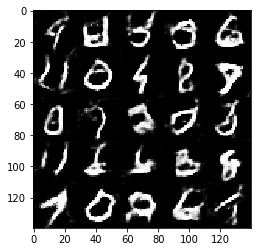

Epoch 1/2.... Batch 910... Discriminator Loss: 1.2431.... Generator Loss: 1.1335
Epoch 1/2.... Batch 920... Discriminator Loss: 1.3114.... Generator Loss: 0.7865
Epoch 1/2.... Batch 930... Discriminator Loss: 1.2226.... Generator Loss: 0.8625
Epoch 1/2.... Batch 940... Discriminator Loss: 1.2190.... Generator Loss: 0.9540
Epoch 1/2.... Batch 950... Discriminator Loss: 1.5090.... Generator Loss: 2.3182
Epoch 1/2.... Batch 960... Discriminator Loss: 1.0760.... Generator Loss: 1.0260
Epoch 1/2.... Batch 970... Discriminator Loss: 1.1671.... Generator Loss: 1.4611
Epoch 1/2.... Batch 980... Discriminator Loss: 1.1191.... Generator Loss: 1.5396
Epoch 1/2.... Batch 990... Discriminator Loss: 1.4187.... Generator Loss: 0.6737
Epoch 1/2.... Batch 1000... Discriminator Loss: 1.9585.... Generator Loss: 0.3878


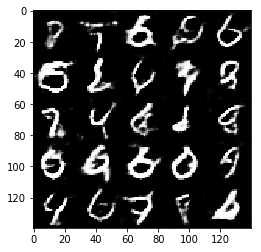

Epoch 1/2.... Batch 1010... Discriminator Loss: 1.0144.... Generator Loss: 1.8297
Epoch 1/2.... Batch 1020... Discriminator Loss: 1.0962.... Generator Loss: 1.3980
Epoch 1/2.... Batch 1030... Discriminator Loss: 1.1439.... Generator Loss: 1.4561
Epoch 1/2.... Batch 1040... Discriminator Loss: 1.3713.... Generator Loss: 1.0317
Epoch 1/2.... Batch 1050... Discriminator Loss: 1.2931.... Generator Loss: 0.7839
Epoch 1/2.... Batch 1060... Discriminator Loss: 1.0777.... Generator Loss: 1.7090
Epoch 1/2.... Batch 1070... Discriminator Loss: 1.0119.... Generator Loss: 1.3943
Epoch 1/2.... Batch 1080... Discriminator Loss: 1.1344.... Generator Loss: 1.0343
Epoch 1/2.... Batch 1090... Discriminator Loss: 1.1041.... Generator Loss: 1.1422
Epoch 1/2.... Batch 1100... Discriminator Loss: 1.3890.... Generator Loss: 0.6279


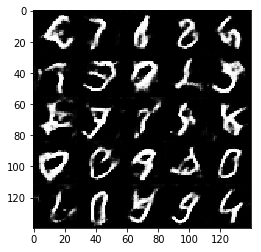

Epoch 1/2.... Batch 1110... Discriminator Loss: 2.0440.... Generator Loss: 0.3491
Epoch 1/2.... Batch 1120... Discriminator Loss: 1.1358.... Generator Loss: 1.2500
Epoch 1/2.... Batch 1130... Discriminator Loss: 1.2978.... Generator Loss: 0.8825
Epoch 1/2.... Batch 1140... Discriminator Loss: 1.2501.... Generator Loss: 1.0370
Epoch 1/2.... Batch 1150... Discriminator Loss: 1.4266.... Generator Loss: 0.8035
Epoch 1/2.... Batch 1160... Discriminator Loss: 1.1819.... Generator Loss: 1.1778
Epoch 1/2.... Batch 1170... Discriminator Loss: 1.2031.... Generator Loss: 0.9304
Epoch 1/2.... Batch 1180... Discriminator Loss: 1.0870.... Generator Loss: 1.1866
Epoch 1/2.... Batch 1190... Discriminator Loss: 1.4604.... Generator Loss: 0.7493
Epoch 1/2.... Batch 1200... Discriminator Loss: 1.1616.... Generator Loss: 0.9410


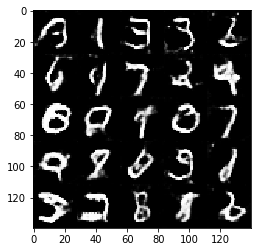

Epoch 1/2.... Batch 1210... Discriminator Loss: 1.2483.... Generator Loss: 0.9618
Epoch 1/2.... Batch 1220... Discriminator Loss: 1.4046.... Generator Loss: 0.6124
Epoch 1/2.... Batch 1230... Discriminator Loss: 1.0966.... Generator Loss: 1.0088
Epoch 1/2.... Batch 1240... Discriminator Loss: 1.5026.... Generator Loss: 0.5596
Epoch 1/2.... Batch 1250... Discriminator Loss: 1.0267.... Generator Loss: 1.5639
Epoch 1/2.... Batch 1260... Discriminator Loss: 1.5591.... Generator Loss: 0.5937
Epoch 1/2.... Batch 1270... Discriminator Loss: 1.3004.... Generator Loss: 0.6910
Epoch 1/2.... Batch 1280... Discriminator Loss: 1.5192.... Generator Loss: 0.5529
Epoch 1/2.... Batch 1290... Discriminator Loss: 1.0411.... Generator Loss: 1.2337
Epoch 1/2.... Batch 1300... Discriminator Loss: 1.1271.... Generator Loss: 1.2742


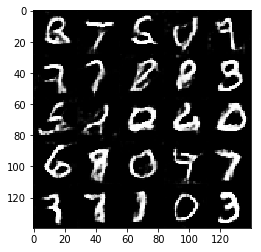

Epoch 1/2.... Batch 1310... Discriminator Loss: 1.2030.... Generator Loss: 1.4026
Epoch 1/2.... Batch 1320... Discriminator Loss: 1.3448.... Generator Loss: 0.7511
Epoch 1/2.... Batch 1330... Discriminator Loss: 1.1402.... Generator Loss: 1.4831
Epoch 1/2.... Batch 1340... Discriminator Loss: 1.2111.... Generator Loss: 1.3847
Epoch 1/2.... Batch 1350... Discriminator Loss: 1.0856.... Generator Loss: 1.3000
Epoch 1/2.... Batch 1360... Discriminator Loss: 1.2483.... Generator Loss: 1.0233
Epoch 1/2.... Batch 1370... Discriminator Loss: 1.5537.... Generator Loss: 0.6695
Epoch 1/2.... Batch 1380... Discriminator Loss: 1.0989.... Generator Loss: 1.0056
Epoch 1/2.... Batch 1390... Discriminator Loss: 1.6297.... Generator Loss: 2.1173
Epoch 1/2.... Batch 1400... Discriminator Loss: 1.2984.... Generator Loss: 0.9336


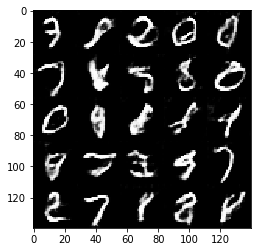

Epoch 1/2.... Batch 1410... Discriminator Loss: 1.1072.... Generator Loss: 1.0765
Epoch 1/2.... Batch 1420... Discriminator Loss: 1.1751.... Generator Loss: 1.0108
Epoch 1/2.... Batch 1430... Discriminator Loss: 1.2697.... Generator Loss: 1.3005
Epoch 1/2.... Batch 1440... Discriminator Loss: 1.1963.... Generator Loss: 1.5982
Epoch 1/2.... Batch 1450... Discriminator Loss: 1.1004.... Generator Loss: 1.2960
Epoch 1/2.... Batch 1460... Discriminator Loss: 1.4449.... Generator Loss: 0.5931
Epoch 1/2.... Batch 1470... Discriminator Loss: 1.1548.... Generator Loss: 1.0877
Epoch 1/2.... Batch 1480... Discriminator Loss: 1.1206.... Generator Loss: 1.7404
Epoch 1/2.... Batch 1490... Discriminator Loss: 1.3182.... Generator Loss: 0.6914
Epoch 1/2.... Batch 1500... Discriminator Loss: 1.2529.... Generator Loss: 1.2185


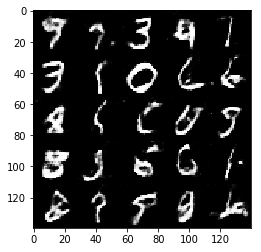

Epoch 1/2.... Batch 1510... Discriminator Loss: 1.3728.... Generator Loss: 1.0461
Epoch 1/2.... Batch 1520... Discriminator Loss: 1.1546.... Generator Loss: 1.0034
Epoch 1/2.... Batch 1530... Discriminator Loss: 1.0547.... Generator Loss: 1.1924
Epoch 1/2.... Batch 1540... Discriminator Loss: 1.1988.... Generator Loss: 1.1123
Epoch 1/2.... Batch 1550... Discriminator Loss: 1.6288.... Generator Loss: 0.4902
Epoch 1/2.... Batch 1560... Discriminator Loss: 1.5530.... Generator Loss: 0.5509
Epoch 1/2.... Batch 1570... Discriminator Loss: 1.5325.... Generator Loss: 0.5582
Epoch 1/2.... Batch 1580... Discriminator Loss: 1.1201.... Generator Loss: 0.9330
Epoch 1/2.... Batch 1590... Discriminator Loss: 1.1576.... Generator Loss: 0.9847
Epoch 1/2.... Batch 1600... Discriminator Loss: 1.0744.... Generator Loss: 1.2722


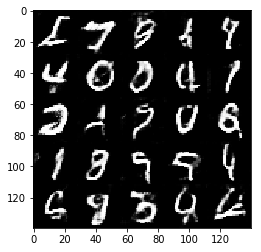

Epoch 1/2.... Batch 1610... Discriminator Loss: 1.0900.... Generator Loss: 1.1874
Epoch 1/2.... Batch 1620... Discriminator Loss: 1.8834.... Generator Loss: 0.3984
Epoch 1/2.... Batch 1630... Discriminator Loss: 1.2001.... Generator Loss: 0.9999
Epoch 1/2.... Batch 1640... Discriminator Loss: 1.0373.... Generator Loss: 1.0925
Epoch 1/2.... Batch 1650... Discriminator Loss: 1.0221.... Generator Loss: 1.8496
Epoch 1/2.... Batch 1660... Discriminator Loss: 1.2717.... Generator Loss: 1.4610
Epoch 1/2.... Batch 1670... Discriminator Loss: 2.2280.... Generator Loss: 0.3253
Epoch 1/2.... Batch 1680... Discriminator Loss: 1.3919.... Generator Loss: 1.9020
Epoch 1/2.... Batch 1690... Discriminator Loss: 1.1609.... Generator Loss: 1.2705
Epoch 1/2.... Batch 1700... Discriminator Loss: 1.2222.... Generator Loss: 1.3915


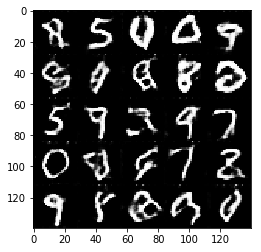

Epoch 1/2.... Batch 1710... Discriminator Loss: 1.0470.... Generator Loss: 1.3452
Epoch 1/2.... Batch 1720... Discriminator Loss: 1.1423.... Generator Loss: 0.9369
Epoch 1/2.... Batch 1730... Discriminator Loss: 1.6138.... Generator Loss: 0.5022
Epoch 1/2.... Batch 1740... Discriminator Loss: 1.0359.... Generator Loss: 1.4395
Epoch 1/2.... Batch 1750... Discriminator Loss: 1.4778.... Generator Loss: 0.6201
Epoch 1/2.... Batch 1760... Discriminator Loss: 0.9959.... Generator Loss: 1.1637
Epoch 1/2.... Batch 1770... Discriminator Loss: 1.5544.... Generator Loss: 0.6005
Epoch 1/2.... Batch 1780... Discriminator Loss: 1.6792.... Generator Loss: 0.5647
Epoch 1/2.... Batch 1790... Discriminator Loss: 2.2063.... Generator Loss: 0.2959
Epoch 1/2.... Batch 1800... Discriminator Loss: 1.1244.... Generator Loss: 0.9303


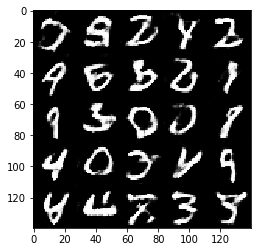

Epoch 1/2.... Batch 1810... Discriminator Loss: 1.2441.... Generator Loss: 0.8774
Epoch 1/2.... Batch 1820... Discriminator Loss: 1.7690.... Generator Loss: 0.4642
Epoch 1/2.... Batch 1830... Discriminator Loss: 1.2492.... Generator Loss: 0.8016
Epoch 1/2.... Batch 1840... Discriminator Loss: 1.1627.... Generator Loss: 0.9791
Epoch 1/2.... Batch 1850... Discriminator Loss: 1.3100.... Generator Loss: 0.7678
Epoch 1/2.... Batch 1860... Discriminator Loss: 1.2962.... Generator Loss: 1.6046
Epoch 1/2.... Batch 1870... Discriminator Loss: 3.0345.... Generator Loss: 0.1512
Epoch 2/2.... Batch 10... Discriminator Loss: 1.1669.... Generator Loss: 1.0878
Epoch 2/2.... Batch 20... Discriminator Loss: 0.9849.... Generator Loss: 1.1422
Epoch 2/2.... Batch 30... Discriminator Loss: 1.3700.... Generator Loss: 1.9226
Epoch 2/2.... Batch 40... Discriminator Loss: 0.9733.... Generator Loss: 1.2598
Epoch 2/2.... Batch 50... Discriminator Loss: 1.3814.... Generator Loss: 2.4101
Epoch 2/2.... Batch 60... 

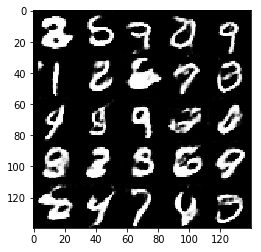

Epoch 2/2.... Batch 110... Discriminator Loss: 1.6576.... Generator Loss: 0.4952
Epoch 2/2.... Batch 120... Discriminator Loss: 1.3309.... Generator Loss: 0.7077
Epoch 2/2.... Batch 130... Discriminator Loss: 1.2106.... Generator Loss: 0.8881
Epoch 2/2.... Batch 140... Discriminator Loss: 1.2513.... Generator Loss: 0.8573
Epoch 2/2.... Batch 150... Discriminator Loss: 1.1885.... Generator Loss: 0.8985
Epoch 2/2.... Batch 160... Discriminator Loss: 2.8194.... Generator Loss: 0.2334
Epoch 2/2.... Batch 170... Discriminator Loss: 1.2088.... Generator Loss: 1.3650
Epoch 2/2.... Batch 180... Discriminator Loss: 1.2971.... Generator Loss: 0.7018
Epoch 2/2.... Batch 190... Discriminator Loss: 1.2521.... Generator Loss: 1.0820
Epoch 2/2.... Batch 200... Discriminator Loss: 1.0303.... Generator Loss: 1.2426


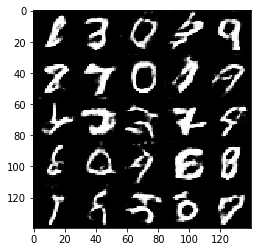

Epoch 2/2.... Batch 210... Discriminator Loss: 1.1014.... Generator Loss: 0.9413
Epoch 2/2.... Batch 220... Discriminator Loss: 2.2322.... Generator Loss: 0.2982
Epoch 2/2.... Batch 230... Discriminator Loss: 0.9812.... Generator Loss: 1.1936
Epoch 2/2.... Batch 240... Discriminator Loss: 1.2759.... Generator Loss: 1.0612
Epoch 2/2.... Batch 250... Discriminator Loss: 1.3591.... Generator Loss: 0.6826
Epoch 2/2.... Batch 260... Discriminator Loss: 1.0081.... Generator Loss: 1.3323
Epoch 2/2.... Batch 270... Discriminator Loss: 0.9166.... Generator Loss: 1.8087
Epoch 2/2.... Batch 280... Discriminator Loss: 1.5229.... Generator Loss: 0.8165
Epoch 2/2.... Batch 290... Discriminator Loss: 1.2373.... Generator Loss: 0.8624
Epoch 2/2.... Batch 300... Discriminator Loss: 1.2185.... Generator Loss: 2.0525


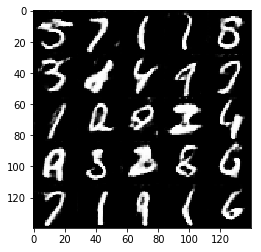

Epoch 2/2.... Batch 310... Discriminator Loss: 1.2452.... Generator Loss: 0.8030
Epoch 2/2.... Batch 320... Discriminator Loss: 1.4099.... Generator Loss: 2.1860
Epoch 2/2.... Batch 330... Discriminator Loss: 1.3645.... Generator Loss: 0.7744
Epoch 2/2.... Batch 340... Discriminator Loss: 1.1385.... Generator Loss: 1.0551
Epoch 2/2.... Batch 350... Discriminator Loss: 0.8496.... Generator Loss: 1.5795
Epoch 2/2.... Batch 360... Discriminator Loss: 1.0206.... Generator Loss: 1.2914
Epoch 2/2.... Batch 370... Discriminator Loss: 1.8860.... Generator Loss: 0.3531
Epoch 2/2.... Batch 380... Discriminator Loss: 0.9468.... Generator Loss: 1.3030
Epoch 2/2.... Batch 390... Discriminator Loss: 0.9488.... Generator Loss: 1.4010
Epoch 2/2.... Batch 400... Discriminator Loss: 1.0492.... Generator Loss: 1.1332


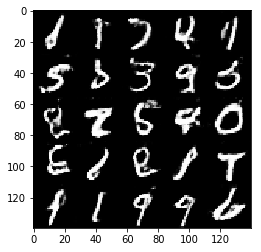

Epoch 2/2.... Batch 410... Discriminator Loss: 0.8632.... Generator Loss: 1.6798
Epoch 2/2.... Batch 420... Discriminator Loss: 0.9615.... Generator Loss: 1.2598
Epoch 2/2.... Batch 430... Discriminator Loss: 1.0852.... Generator Loss: 1.1575
Epoch 2/2.... Batch 440... Discriminator Loss: 0.8576.... Generator Loss: 2.1633
Epoch 2/2.... Batch 450... Discriminator Loss: 0.9967.... Generator Loss: 1.4321
Epoch 2/2.... Batch 460... Discriminator Loss: 1.3710.... Generator Loss: 0.6452
Epoch 2/2.... Batch 470... Discriminator Loss: 1.1770.... Generator Loss: 0.9416
Epoch 2/2.... Batch 480... Discriminator Loss: 1.2618.... Generator Loss: 1.7740
Epoch 2/2.... Batch 490... Discriminator Loss: 1.1341.... Generator Loss: 0.9752
Epoch 2/2.... Batch 500... Discriminator Loss: 1.1250.... Generator Loss: 0.9134


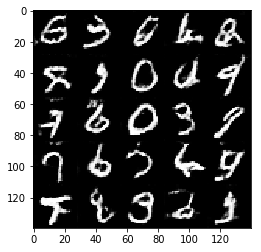

Epoch 2/2.... Batch 510... Discriminator Loss: 1.2537.... Generator Loss: 1.0793
Epoch 2/2.... Batch 520... Discriminator Loss: 1.0750.... Generator Loss: 1.1672
Epoch 2/2.... Batch 530... Discriminator Loss: 1.0893.... Generator Loss: 2.1562
Epoch 2/2.... Batch 540... Discriminator Loss: 1.1830.... Generator Loss: 0.8568
Epoch 2/2.... Batch 550... Discriminator Loss: 1.3809.... Generator Loss: 0.7195
Epoch 2/2.... Batch 560... Discriminator Loss: 1.2682.... Generator Loss: 2.7101
Epoch 2/2.... Batch 570... Discriminator Loss: 1.1219.... Generator Loss: 1.0626
Epoch 2/2.... Batch 580... Discriminator Loss: 1.0666.... Generator Loss: 1.2956
Epoch 2/2.... Batch 590... Discriminator Loss: 1.1736.... Generator Loss: 2.5756
Epoch 2/2.... Batch 600... Discriminator Loss: 1.0453.... Generator Loss: 1.3990


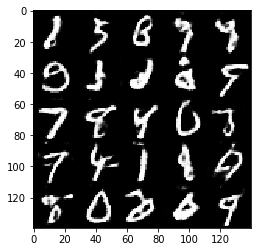

Epoch 2/2.... Batch 610... Discriminator Loss: 1.1132.... Generator Loss: 1.0267
Epoch 2/2.... Batch 620... Discriminator Loss: 2.0235.... Generator Loss: 0.3118
Epoch 2/2.... Batch 630... Discriminator Loss: 1.1161.... Generator Loss: 1.6046
Epoch 2/2.... Batch 640... Discriminator Loss: 0.8902.... Generator Loss: 1.6852
Epoch 2/2.... Batch 650... Discriminator Loss: 1.5052.... Generator Loss: 0.7046
Epoch 2/2.... Batch 660... Discriminator Loss: 1.3318.... Generator Loss: 3.5135
Epoch 2/2.... Batch 670... Discriminator Loss: 1.0058.... Generator Loss: 1.3845
Epoch 2/2.... Batch 680... Discriminator Loss: 1.2293.... Generator Loss: 0.8113
Epoch 2/2.... Batch 690... Discriminator Loss: 1.3473.... Generator Loss: 0.8222
Epoch 2/2.... Batch 700... Discriminator Loss: 1.0190.... Generator Loss: 1.4639


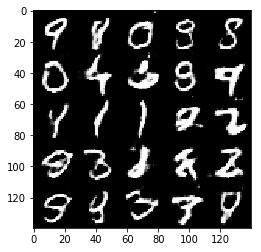

Epoch 2/2.... Batch 710... Discriminator Loss: 0.8266.... Generator Loss: 1.8098
Epoch 2/2.... Batch 720... Discriminator Loss: 1.0785.... Generator Loss: 1.7893
Epoch 2/2.... Batch 730... Discriminator Loss: 0.9112.... Generator Loss: 1.3592
Epoch 2/2.... Batch 740... Discriminator Loss: 1.2261.... Generator Loss: 2.3914
Epoch 2/2.... Batch 750... Discriminator Loss: 0.8514.... Generator Loss: 1.4681
Epoch 2/2.... Batch 760... Discriminator Loss: 1.0479.... Generator Loss: 1.0665
Epoch 2/2.... Batch 770... Discriminator Loss: 1.1122.... Generator Loss: 1.9997
Epoch 2/2.... Batch 780... Discriminator Loss: 2.0378.... Generator Loss: 3.9137
Epoch 2/2.... Batch 790... Discriminator Loss: 1.1136.... Generator Loss: 1.6688
Epoch 2/2.... Batch 800... Discriminator Loss: 1.9873.... Generator Loss: 0.4061


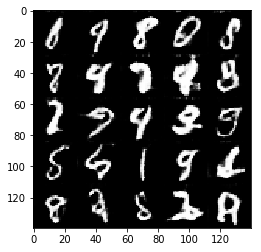

Epoch 2/2.... Batch 810... Discriminator Loss: 0.9451.... Generator Loss: 1.3456
Epoch 2/2.... Batch 820... Discriminator Loss: 0.6805.... Generator Loss: 3.2625
Epoch 2/2.... Batch 830... Discriminator Loss: 1.0197.... Generator Loss: 1.4221
Epoch 2/2.... Batch 840... Discriminator Loss: 1.1072.... Generator Loss: 1.0790
Epoch 2/2.... Batch 850... Discriminator Loss: 0.9555.... Generator Loss: 1.2761
Epoch 2/2.... Batch 860... Discriminator Loss: 0.7569.... Generator Loss: 2.1245
Epoch 2/2.... Batch 870... Discriminator Loss: 2.0349.... Generator Loss: 4.3812
Epoch 2/2.... Batch 880... Discriminator Loss: 1.5121.... Generator Loss: 0.6467
Epoch 2/2.... Batch 890... Discriminator Loss: 0.9873.... Generator Loss: 1.7371
Epoch 2/2.... Batch 900... Discriminator Loss: 1.2002.... Generator Loss: 0.9443


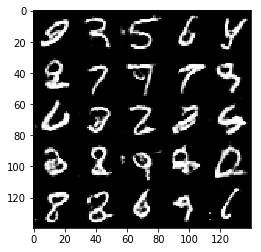

Epoch 2/2.... Batch 910... Discriminator Loss: 1.2309.... Generator Loss: 1.0001
Epoch 2/2.... Batch 920... Discriminator Loss: 1.1515.... Generator Loss: 0.8928
Epoch 2/2.... Batch 930... Discriminator Loss: 0.9566.... Generator Loss: 2.3606
Epoch 2/2.... Batch 940... Discriminator Loss: 0.9779.... Generator Loss: 1.4496
Epoch 2/2.... Batch 950... Discriminator Loss: 0.9654.... Generator Loss: 1.5074
Epoch 2/2.... Batch 960... Discriminator Loss: 0.9591.... Generator Loss: 1.6187
Epoch 2/2.... Batch 970... Discriminator Loss: 0.8140.... Generator Loss: 1.6533
Epoch 2/2.... Batch 980... Discriminator Loss: 0.7080.... Generator Loss: 2.4435
Epoch 2/2.... Batch 990... Discriminator Loss: 1.9346.... Generator Loss: 0.5456
Epoch 2/2.... Batch 1000... Discriminator Loss: 0.9610.... Generator Loss: 1.4095


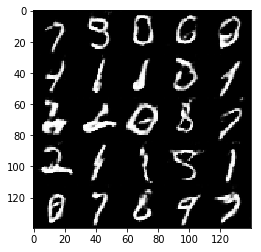

Epoch 2/2.... Batch 1010... Discriminator Loss: 0.7781.... Generator Loss: 2.2144
Epoch 2/2.... Batch 1020... Discriminator Loss: 0.8099.... Generator Loss: 1.7618
Epoch 2/2.... Batch 1030... Discriminator Loss: 0.9917.... Generator Loss: 1.1330
Epoch 2/2.... Batch 1040... Discriminator Loss: 1.5619.... Generator Loss: 0.5643
Epoch 2/2.... Batch 1050... Discriminator Loss: 0.8096.... Generator Loss: 1.9564
Epoch 2/2.... Batch 1060... Discriminator Loss: 1.0275.... Generator Loss: 1.0598
Epoch 2/2.... Batch 1070... Discriminator Loss: 1.0995.... Generator Loss: 0.9312
Epoch 2/2.... Batch 1080... Discriminator Loss: 1.0073.... Generator Loss: 1.1797
Epoch 2/2.... Batch 1090... Discriminator Loss: 1.5666.... Generator Loss: 0.7297
Epoch 2/2.... Batch 1100... Discriminator Loss: 0.7822.... Generator Loss: 1.9242


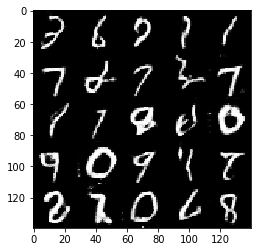

Epoch 2/2.... Batch 1110... Discriminator Loss: 1.2702.... Generator Loss: 0.8604
Epoch 2/2.... Batch 1120... Discriminator Loss: 1.5058.... Generator Loss: 0.7921
Epoch 2/2.... Batch 1130... Discriminator Loss: 0.7677.... Generator Loss: 1.7832
Epoch 2/2.... Batch 1140... Discriminator Loss: 1.2732.... Generator Loss: 0.8316
Epoch 2/2.... Batch 1150... Discriminator Loss: 0.9307.... Generator Loss: 1.2827
Epoch 2/2.... Batch 1160... Discriminator Loss: 1.5368.... Generator Loss: 0.6188
Epoch 2/2.... Batch 1170... Discriminator Loss: 0.8867.... Generator Loss: 2.6475
Epoch 2/2.... Batch 1180... Discriminator Loss: 1.4051.... Generator Loss: 0.7952
Epoch 2/2.... Batch 1190... Discriminator Loss: 0.8986.... Generator Loss: 1.3725
Epoch 2/2.... Batch 1200... Discriminator Loss: 0.9072.... Generator Loss: 2.6814


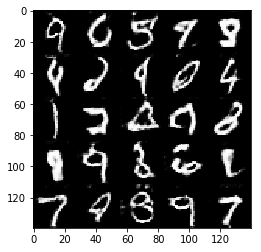

Epoch 2/2.... Batch 1210... Discriminator Loss: 0.9362.... Generator Loss: 1.2990
Epoch 2/2.... Batch 1220... Discriminator Loss: 1.0242.... Generator Loss: 1.1835
Epoch 2/2.... Batch 1230... Discriminator Loss: 0.8072.... Generator Loss: 2.0312
Epoch 2/2.... Batch 1240... Discriminator Loss: 0.8939.... Generator Loss: 1.4216
Epoch 2/2.... Batch 1250... Discriminator Loss: 1.0535.... Generator Loss: 2.7326
Epoch 2/2.... Batch 1260... Discriminator Loss: 0.9931.... Generator Loss: 1.3485
Epoch 2/2.... Batch 1270... Discriminator Loss: 0.8368.... Generator Loss: 1.5586
Epoch 2/2.... Batch 1280... Discriminator Loss: 1.0175.... Generator Loss: 1.9255
Epoch 2/2.... Batch 1290... Discriminator Loss: 0.9337.... Generator Loss: 1.3785
Epoch 2/2.... Batch 1300... Discriminator Loss: 0.8403.... Generator Loss: 1.7712


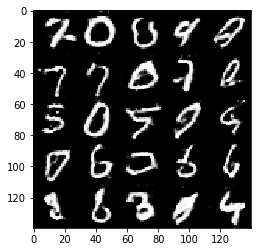

Epoch 2/2.... Batch 1310... Discriminator Loss: 1.2786.... Generator Loss: 0.8279
Epoch 2/2.... Batch 1320... Discriminator Loss: 0.9478.... Generator Loss: 1.3574
Epoch 2/2.... Batch 1330... Discriminator Loss: 0.8712.... Generator Loss: 1.7106
Epoch 2/2.... Batch 1340... Discriminator Loss: 0.9561.... Generator Loss: 1.2614
Epoch 2/2.... Batch 1350... Discriminator Loss: 0.8285.... Generator Loss: 1.7646
Epoch 2/2.... Batch 1360... Discriminator Loss: 1.5399.... Generator Loss: 0.5930
Epoch 2/2.... Batch 1370... Discriminator Loss: 0.9175.... Generator Loss: 2.0537
Epoch 2/2.... Batch 1380... Discriminator Loss: 0.9237.... Generator Loss: 2.3616
Epoch 2/2.... Batch 1390... Discriminator Loss: 1.1092.... Generator Loss: 1.0533
Epoch 2/2.... Batch 1400... Discriminator Loss: 1.2509.... Generator Loss: 0.7875


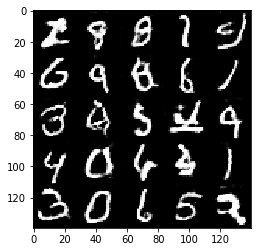

Epoch 2/2.... Batch 1410... Discriminator Loss: 0.8909.... Generator Loss: 1.5157
Epoch 2/2.... Batch 1420... Discriminator Loss: 0.9981.... Generator Loss: 2.5493
Epoch 2/2.... Batch 1430... Discriminator Loss: 0.8424.... Generator Loss: 1.7234
Epoch 2/2.... Batch 1440... Discriminator Loss: 0.8959.... Generator Loss: 1.8827
Epoch 2/2.... Batch 1450... Discriminator Loss: 1.0387.... Generator Loss: 2.3601
Epoch 2/2.... Batch 1460... Discriminator Loss: 1.5883.... Generator Loss: 0.6288
Epoch 2/2.... Batch 1470... Discriminator Loss: 1.1115.... Generator Loss: 1.1497
Epoch 2/2.... Batch 1480... Discriminator Loss: 0.8792.... Generator Loss: 1.4222
Epoch 2/2.... Batch 1490... Discriminator Loss: 1.2114.... Generator Loss: 0.8078
Epoch 2/2.... Batch 1500... Discriminator Loss: 1.0104.... Generator Loss: 1.2385


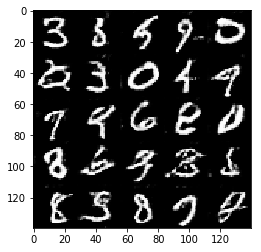

Epoch 2/2.... Batch 1510... Discriminator Loss: 1.2406.... Generator Loss: 0.9177
Epoch 2/2.... Batch 1520... Discriminator Loss: 0.7462.... Generator Loss: 1.9718
Epoch 2/2.... Batch 1530... Discriminator Loss: 1.0821.... Generator Loss: 1.0824
Epoch 2/2.... Batch 1540... Discriminator Loss: 1.6059.... Generator Loss: 0.6360
Epoch 2/2.... Batch 1550... Discriminator Loss: 0.9405.... Generator Loss: 1.3310
Epoch 2/2.... Batch 1560... Discriminator Loss: 1.3825.... Generator Loss: 0.6448
Epoch 2/2.... Batch 1570... Discriminator Loss: 1.2503.... Generator Loss: 0.9450
Epoch 2/2.... Batch 1580... Discriminator Loss: 1.0331.... Generator Loss: 1.0310
Epoch 2/2.... Batch 1590... Discriminator Loss: 1.5863.... Generator Loss: 0.5478
Epoch 2/2.... Batch 1600... Discriminator Loss: 1.0600.... Generator Loss: 1.1242


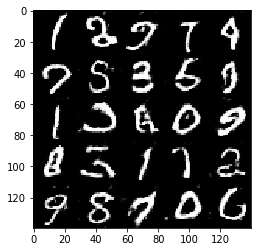

Epoch 2/2.... Batch 1610... Discriminator Loss: 1.0046.... Generator Loss: 1.2073
Epoch 2/2.... Batch 1620... Discriminator Loss: 1.0767.... Generator Loss: 1.1049
Epoch 2/2.... Batch 1630... Discriminator Loss: 0.8546.... Generator Loss: 2.1628
Epoch 2/2.... Batch 1640... Discriminator Loss: 0.8268.... Generator Loss: 1.7754
Epoch 2/2.... Batch 1650... Discriminator Loss: 0.8072.... Generator Loss: 2.4807
Epoch 2/2.... Batch 1660... Discriminator Loss: 0.8527.... Generator Loss: 2.2174
Epoch 2/2.... Batch 1670... Discriminator Loss: 1.1310.... Generator Loss: 1.0886
Epoch 2/2.... Batch 1680... Discriminator Loss: 0.8581.... Generator Loss: 1.9239
Epoch 2/2.... Batch 1690... Discriminator Loss: 1.6313.... Generator Loss: 0.6777
Epoch 2/2.... Batch 1700... Discriminator Loss: 0.9433.... Generator Loss: 2.0572


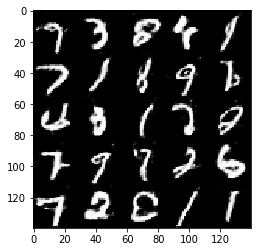

Epoch 2/2.... Batch 1710... Discriminator Loss: 0.9640.... Generator Loss: 1.2911
Epoch 2/2.... Batch 1720... Discriminator Loss: 0.8623.... Generator Loss: 1.5977
Epoch 2/2.... Batch 1730... Discriminator Loss: 1.1517.... Generator Loss: 1.1785
Epoch 2/2.... Batch 1740... Discriminator Loss: 0.9185.... Generator Loss: 1.7748
Epoch 2/2.... Batch 1750... Discriminator Loss: 1.5683.... Generator Loss: 0.5419
Epoch 2/2.... Batch 1760... Discriminator Loss: 0.8168.... Generator Loss: 1.6164
Epoch 2/2.... Batch 1770... Discriminator Loss: 1.0186.... Generator Loss: 1.1585
Epoch 2/2.... Batch 1780... Discriminator Loss: 0.7847.... Generator Loss: 2.6500
Epoch 2/2.... Batch 1790... Discriminator Loss: 0.8439.... Generator Loss: 1.5256
Epoch 2/2.... Batch 1800... Discriminator Loss: 1.0174.... Generator Loss: 2.1355


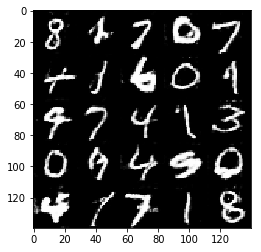

Epoch 2/2.... Batch 1810... Discriminator Loss: 0.9160.... Generator Loss: 1.4210
Epoch 2/2.... Batch 1820... Discriminator Loss: 0.9252.... Generator Loss: 1.9728
Epoch 2/2.... Batch 1830... Discriminator Loss: 1.6294.... Generator Loss: 0.7355
Epoch 2/2.... Batch 1840... Discriminator Loss: 0.9939.... Generator Loss: 1.2415
Epoch 2/2.... Batch 1850... Discriminator Loss: 0.7623.... Generator Loss: 1.8959
Epoch 2/2.... Batch 1860... Discriminator Loss: 1.0600.... Generator Loss: 2.6332
Epoch 2/2.... Batch 1870... Discriminator Loss: 1.3518.... Generator Loss: 0.7932


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1.... Batch 10... Discriminator Loss: 10.1380.... Generator Loss: 0.0021
Epoch 1/1.... Batch 20... Discriminator Loss: 3.4722.... Generator Loss: 0.9793
Epoch 1/1.... Batch 30... Discriminator Loss: 1.8347.... Generator Loss: 5.9237
Epoch 1/1.... Batch 40... Discriminator Loss: 3.8453.... Generator Loss: 3.5415
Epoch 1/1.... Batch 50... Discriminator Loss: 1.6537.... Generator Loss: 5.7039
Epoch 1/1.... Batch 60... Discriminator Loss: 2.5162.... Generator Loss: 7.0036
Epoch 1/1.... Batch 70... Discriminator Loss: 1.5054.... Generator Loss: 2.2901
Epoch 1/1.... Batch 80... Discriminator Loss: 1.3126.... Generator Loss: 1.7715
Epoch 1/1.... Batch 90... Discriminator Loss: 4.5499.... Generator Loss: 9.2111
Epoch 1/1.... Batch 100... Discriminator Loss: 2.2857.... Generator Loss: 2.0027


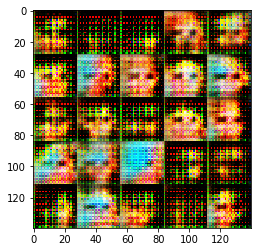

Epoch 1/1.... Batch 110... Discriminator Loss: 1.2656.... Generator Loss: 3.3693
Epoch 1/1.... Batch 120... Discriminator Loss: 0.7417.... Generator Loss: 1.9555
Epoch 1/1.... Batch 130... Discriminator Loss: 1.2803.... Generator Loss: 1.3526
Epoch 1/1.... Batch 140... Discriminator Loss: 2.1310.... Generator Loss: 0.7096
Epoch 1/1.... Batch 150... Discriminator Loss: 1.1033.... Generator Loss: 2.3003
Epoch 1/1.... Batch 160... Discriminator Loss: 1.3687.... Generator Loss: 1.8816
Epoch 1/1.... Batch 170... Discriminator Loss: 1.1679.... Generator Loss: 1.0307
Epoch 1/1.... Batch 180... Discriminator Loss: 3.9314.... Generator Loss: 3.9288
Epoch 1/1.... Batch 190... Discriminator Loss: 1.9333.... Generator Loss: 0.5285
Epoch 1/1.... Batch 200... Discriminator Loss: 1.1854.... Generator Loss: 1.3136


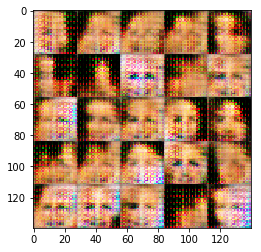

Epoch 1/1.... Batch 210... Discriminator Loss: 1.0870.... Generator Loss: 1.6203
Epoch 1/1.... Batch 220... Discriminator Loss: 1.6373.... Generator Loss: 1.2432
Epoch 1/1.... Batch 230... Discriminator Loss: 1.4836.... Generator Loss: 0.6658
Epoch 1/1.... Batch 240... Discriminator Loss: 0.9821.... Generator Loss: 1.3024
Epoch 1/1.... Batch 250... Discriminator Loss: 1.2955.... Generator Loss: 1.1419
Epoch 1/1.... Batch 260... Discriminator Loss: 1.1317.... Generator Loss: 1.5867
Epoch 1/1.... Batch 270... Discriminator Loss: 1.2866.... Generator Loss: 1.2357
Epoch 1/1.... Batch 280... Discriminator Loss: 2.3892.... Generator Loss: 3.1243
Epoch 1/1.... Batch 290... Discriminator Loss: 1.2243.... Generator Loss: 1.3699
Epoch 1/1.... Batch 300... Discriminator Loss: 1.5535.... Generator Loss: 0.7320


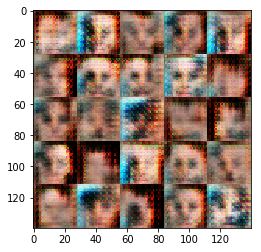

Epoch 1/1.... Batch 310... Discriminator Loss: 1.3014.... Generator Loss: 1.0861
Epoch 1/1.... Batch 320... Discriminator Loss: 1.0110.... Generator Loss: 1.4450
Epoch 1/1.... Batch 330... Discriminator Loss: 1.3013.... Generator Loss: 1.2242
Epoch 1/1.... Batch 340... Discriminator Loss: 1.0974.... Generator Loss: 1.1787
Epoch 1/1.... Batch 350... Discriminator Loss: 1.1166.... Generator Loss: 1.4262
Epoch 1/1.... Batch 360... Discriminator Loss: 1.5529.... Generator Loss: 0.8773
Epoch 1/1.... Batch 370... Discriminator Loss: 2.7873.... Generator Loss: 0.2014
Epoch 1/1.... Batch 380... Discriminator Loss: 1.4093.... Generator Loss: 0.9886
Epoch 1/1.... Batch 390... Discriminator Loss: 1.0920.... Generator Loss: 1.5867
Epoch 1/1.... Batch 400... Discriminator Loss: 0.9298.... Generator Loss: 1.3564


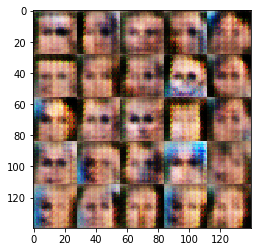

Epoch 1/1.... Batch 410... Discriminator Loss: 1.2493.... Generator Loss: 1.6571
Epoch 1/1.... Batch 420... Discriminator Loss: 1.2825.... Generator Loss: 0.8034
Epoch 1/1.... Batch 430... Discriminator Loss: 1.2014.... Generator Loss: 1.0045
Epoch 1/1.... Batch 440... Discriminator Loss: 1.2729.... Generator Loss: 1.2212
Epoch 1/1.... Batch 450... Discriminator Loss: 1.4238.... Generator Loss: 1.4243
Epoch 1/1.... Batch 460... Discriminator Loss: 2.6802.... Generator Loss: 2.0801
Epoch 1/1.... Batch 470... Discriminator Loss: 1.5403.... Generator Loss: 0.9683
Epoch 1/1.... Batch 480... Discriminator Loss: 1.2540.... Generator Loss: 1.0587
Epoch 1/1.... Batch 490... Discriminator Loss: 1.0457.... Generator Loss: 1.6966
Epoch 1/1.... Batch 500... Discriminator Loss: 1.3681.... Generator Loss: 0.9593


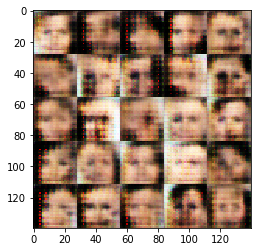

Epoch 1/1.... Batch 510... Discriminator Loss: 0.9960.... Generator Loss: 1.5169
Epoch 1/1.... Batch 520... Discriminator Loss: 1.3088.... Generator Loss: 1.4838
Epoch 1/1.... Batch 530... Discriminator Loss: 1.0503.... Generator Loss: 1.1136
Epoch 1/1.... Batch 540... Discriminator Loss: 1.2406.... Generator Loss: 0.9818
Epoch 1/1.... Batch 550... Discriminator Loss: 1.1098.... Generator Loss: 1.5126
Epoch 1/1.... Batch 560... Discriminator Loss: 0.9576.... Generator Loss: 1.4735
Epoch 1/1.... Batch 570... Discriminator Loss: 1.3281.... Generator Loss: 1.4880
Epoch 1/1.... Batch 580... Discriminator Loss: 1.1357.... Generator Loss: 1.2651
Epoch 1/1.... Batch 590... Discriminator Loss: 1.4061.... Generator Loss: 1.4283
Epoch 1/1.... Batch 600... Discriminator Loss: 1.3024.... Generator Loss: 1.4633


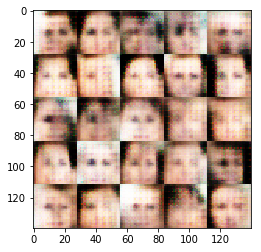

Epoch 1/1.... Batch 610... Discriminator Loss: 1.0752.... Generator Loss: 1.2887
Epoch 1/1.... Batch 620... Discriminator Loss: 2.0106.... Generator Loss: 3.1584
Epoch 1/1.... Batch 630... Discriminator Loss: 1.2512.... Generator Loss: 1.1645
Epoch 1/1.... Batch 640... Discriminator Loss: 1.0764.... Generator Loss: 1.0015
Epoch 1/1.... Batch 650... Discriminator Loss: 1.7007.... Generator Loss: 0.5647
Epoch 1/1.... Batch 660... Discriminator Loss: 1.4702.... Generator Loss: 0.7204
Epoch 1/1.... Batch 670... Discriminator Loss: 1.3088.... Generator Loss: 1.4433
Epoch 1/1.... Batch 680... Discriminator Loss: 1.2058.... Generator Loss: 1.5817
Epoch 1/1.... Batch 690... Discriminator Loss: 2.0338.... Generator Loss: 1.2334
Epoch 1/1.... Batch 700... Discriminator Loss: 1.1546.... Generator Loss: 1.3842


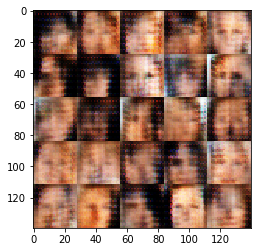

Epoch 1/1.... Batch 710... Discriminator Loss: 1.3124.... Generator Loss: 0.7916
Epoch 1/1.... Batch 720... Discriminator Loss: 1.0040.... Generator Loss: 1.8583
Epoch 1/1.... Batch 730... Discriminator Loss: 1.1975.... Generator Loss: 0.8844
Epoch 1/1.... Batch 740... Discriminator Loss: 1.3792.... Generator Loss: 1.7626
Epoch 1/1.... Batch 750... Discriminator Loss: 1.3556.... Generator Loss: 1.2503
Epoch 1/1.... Batch 760... Discriminator Loss: 0.9207.... Generator Loss: 1.4205
Epoch 1/1.... Batch 770... Discriminator Loss: 1.1128.... Generator Loss: 1.2051
Epoch 1/1.... Batch 780... Discriminator Loss: 1.1718.... Generator Loss: 1.3834
Epoch 1/1.... Batch 790... Discriminator Loss: 1.2491.... Generator Loss: 0.9933
Epoch 1/1.... Batch 800... Discriminator Loss: 1.3408.... Generator Loss: 1.6365


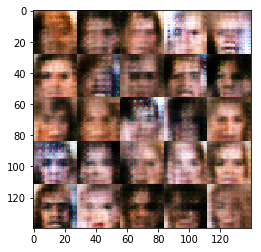

Epoch 1/1.... Batch 810... Discriminator Loss: 2.0187.... Generator Loss: 2.7098
Epoch 1/1.... Batch 820... Discriminator Loss: 1.1805.... Generator Loss: 0.9408
Epoch 1/1.... Batch 830... Discriminator Loss: 2.0085.... Generator Loss: 0.3222
Epoch 1/1.... Batch 840... Discriminator Loss: 1.2709.... Generator Loss: 1.3063
Epoch 1/1.... Batch 850... Discriminator Loss: 0.9842.... Generator Loss: 1.2411
Epoch 1/1.... Batch 860... Discriminator Loss: 1.3526.... Generator Loss: 1.7616
Epoch 1/1.... Batch 870... Discriminator Loss: 1.1357.... Generator Loss: 1.0185
Epoch 1/1.... Batch 880... Discriminator Loss: 1.2570.... Generator Loss: 1.0789
Epoch 1/1.... Batch 890... Discriminator Loss: 1.2966.... Generator Loss: 0.8847
Epoch 1/1.... Batch 900... Discriminator Loss: 0.9453.... Generator Loss: 1.2501


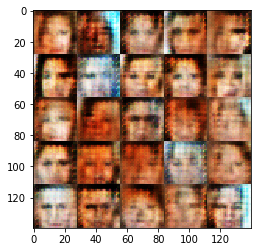

Epoch 1/1.... Batch 910... Discriminator Loss: 1.2231.... Generator Loss: 1.3681
Epoch 1/1.... Batch 920... Discriminator Loss: 1.1001.... Generator Loss: 1.0806
Epoch 1/1.... Batch 930... Discriminator Loss: 1.0872.... Generator Loss: 0.8941
Epoch 1/1.... Batch 940... Discriminator Loss: 1.1372.... Generator Loss: 1.0871
Epoch 1/1.... Batch 950... Discriminator Loss: 1.3457.... Generator Loss: 2.1531
Epoch 1/1.... Batch 960... Discriminator Loss: 1.6544.... Generator Loss: 0.5007
Epoch 1/1.... Batch 970... Discriminator Loss: 1.0728.... Generator Loss: 1.3437
Epoch 1/1.... Batch 980... Discriminator Loss: 1.3775.... Generator Loss: 0.8533
Epoch 1/1.... Batch 990... Discriminator Loss: 1.1511.... Generator Loss: 1.0735
Epoch 1/1.... Batch 1000... Discriminator Loss: 1.2548.... Generator Loss: 0.7824


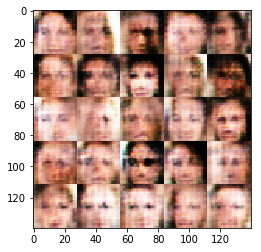

Epoch 1/1.... Batch 1010... Discriminator Loss: 0.8011.... Generator Loss: 1.6456
Epoch 1/1.... Batch 1020... Discriminator Loss: 1.1613.... Generator Loss: 1.4847
Epoch 1/1.... Batch 1030... Discriminator Loss: 1.2369.... Generator Loss: 0.9230
Epoch 1/1.... Batch 1040... Discriminator Loss: 1.1779.... Generator Loss: 1.1178
Epoch 1/1.... Batch 1050... Discriminator Loss: 1.1034.... Generator Loss: 1.0293
Epoch 1/1.... Batch 1060... Discriminator Loss: 1.3680.... Generator Loss: 0.7435
Epoch 1/1.... Batch 1070... Discriminator Loss: 1.0321.... Generator Loss: 1.2033
Epoch 1/1.... Batch 1080... Discriminator Loss: 1.0307.... Generator Loss: 1.1019
Epoch 1/1.... Batch 1090... Discriminator Loss: 1.2127.... Generator Loss: 2.3979
Epoch 1/1.... Batch 1100... Discriminator Loss: 1.2475.... Generator Loss: 0.9418


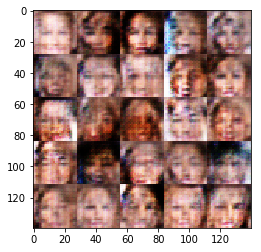

Epoch 1/1.... Batch 1110... Discriminator Loss: 1.2124.... Generator Loss: 0.9610
Epoch 1/1.... Batch 1120... Discriminator Loss: 0.9304.... Generator Loss: 1.3963
Epoch 1/1.... Batch 1130... Discriminator Loss: 1.0960.... Generator Loss: 1.1943
Epoch 1/1.... Batch 1140... Discriminator Loss: 1.2744.... Generator Loss: 1.0392
Epoch 1/1.... Batch 1150... Discriminator Loss: 1.3345.... Generator Loss: 1.7946
Epoch 1/1.... Batch 1160... Discriminator Loss: 1.1918.... Generator Loss: 1.3113
Epoch 1/1.... Batch 1170... Discriminator Loss: 1.1654.... Generator Loss: 1.0666
Epoch 1/1.... Batch 1180... Discriminator Loss: 1.3873.... Generator Loss: 0.5967
Epoch 1/1.... Batch 1190... Discriminator Loss: 1.5317.... Generator Loss: 0.5743
Epoch 1/1.... Batch 1200... Discriminator Loss: 1.0568.... Generator Loss: 1.1413


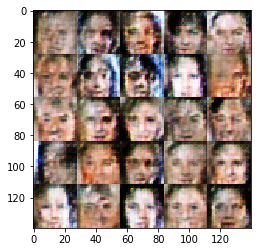

Epoch 1/1.... Batch 1210... Discriminator Loss: 1.3707.... Generator Loss: 0.6751
Epoch 1/1.... Batch 1220... Discriminator Loss: 0.9029.... Generator Loss: 1.5138
Epoch 1/1.... Batch 1230... Discriminator Loss: 1.1255.... Generator Loss: 1.4286
Epoch 1/1.... Batch 1240... Discriminator Loss: 0.8558.... Generator Loss: 1.4595
Epoch 1/1.... Batch 1250... Discriminator Loss: 1.2708.... Generator Loss: 1.3984
Epoch 1/1.... Batch 1260... Discriminator Loss: 1.3565.... Generator Loss: 1.7490
Epoch 1/1.... Batch 1270... Discriminator Loss: 1.3082.... Generator Loss: 1.9442
Epoch 1/1.... Batch 1280... Discriminator Loss: 1.7525.... Generator Loss: 2.2169
Epoch 1/1.... Batch 1290... Discriminator Loss: 1.0766.... Generator Loss: 1.9620
Epoch 1/1.... Batch 1300... Discriminator Loss: 1.2845.... Generator Loss: 1.7906


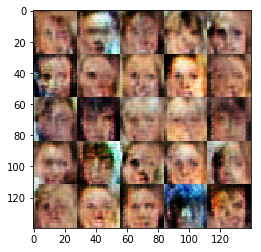

Epoch 1/1.... Batch 1310... Discriminator Loss: 1.1009.... Generator Loss: 1.7346
Epoch 1/1.... Batch 1320... Discriminator Loss: 1.3880.... Generator Loss: 0.7014
Epoch 1/1.... Batch 1330... Discriminator Loss: 1.0650.... Generator Loss: 1.3873
Epoch 1/1.... Batch 1340... Discriminator Loss: 1.6317.... Generator Loss: 0.4581
Epoch 1/1.... Batch 1350... Discriminator Loss: 1.2127.... Generator Loss: 1.0428
Epoch 1/1.... Batch 1360... Discriminator Loss: 1.2006.... Generator Loss: 1.0909
Epoch 1/1.... Batch 1370... Discriminator Loss: 1.7176.... Generator Loss: 2.0383
Epoch 1/1.... Batch 1380... Discriminator Loss: 1.2440.... Generator Loss: 0.8605
Epoch 1/1.... Batch 1390... Discriminator Loss: 0.8586.... Generator Loss: 1.5025
Epoch 1/1.... Batch 1400... Discriminator Loss: 1.1366.... Generator Loss: 1.1359


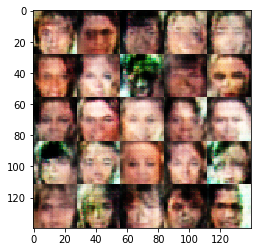

Epoch 1/1.... Batch 1410... Discriminator Loss: 1.0859.... Generator Loss: 1.6656
Epoch 1/1.... Batch 1420... Discriminator Loss: 1.4477.... Generator Loss: 0.6412
Epoch 1/1.... Batch 1430... Discriminator Loss: 1.3209.... Generator Loss: 0.8642
Epoch 1/1.... Batch 1440... Discriminator Loss: 1.0955.... Generator Loss: 0.9735
Epoch 1/1.... Batch 1450... Discriminator Loss: 1.1674.... Generator Loss: 1.0995
Epoch 1/1.... Batch 1460... Discriminator Loss: 1.1481.... Generator Loss: 1.0011
Epoch 1/1.... Batch 1470... Discriminator Loss: 1.3830.... Generator Loss: 0.7722
Epoch 1/1.... Batch 1480... Discriminator Loss: 1.2682.... Generator Loss: 0.9200
Epoch 1/1.... Batch 1490... Discriminator Loss: 1.0695.... Generator Loss: 1.1451
Epoch 1/1.... Batch 1500... Discriminator Loss: 1.2685.... Generator Loss: 0.9244


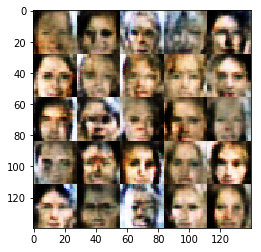

Epoch 1/1.... Batch 1510... Discriminator Loss: 1.2257.... Generator Loss: 0.9634
Epoch 1/1.... Batch 1520... Discriminator Loss: 1.2745.... Generator Loss: 1.9667
Epoch 1/1.... Batch 1530... Discriminator Loss: 1.5871.... Generator Loss: 2.1913
Epoch 1/1.... Batch 1540... Discriminator Loss: 1.4125.... Generator Loss: 0.6749
Epoch 1/1.... Batch 1550... Discriminator Loss: 1.2863.... Generator Loss: 0.9338
Epoch 1/1.... Batch 1560... Discriminator Loss: 1.0810.... Generator Loss: 1.0652
Epoch 1/1.... Batch 1570... Discriminator Loss: 1.8834.... Generator Loss: 0.3555
Epoch 1/1.... Batch 1580... Discriminator Loss: 1.2327.... Generator Loss: 0.9085
Epoch 1/1.... Batch 1590... Discriminator Loss: 1.3051.... Generator Loss: 0.7580
Epoch 1/1.... Batch 1600... Discriminator Loss: 1.2226.... Generator Loss: 1.3514


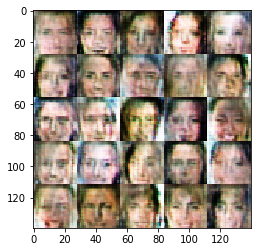

Epoch 1/1.... Batch 1610... Discriminator Loss: 1.3070.... Generator Loss: 1.6460
Epoch 1/1.... Batch 1620... Discriminator Loss: 1.3567.... Generator Loss: 0.9455
Epoch 1/1.... Batch 1630... Discriminator Loss: 1.1265.... Generator Loss: 1.6208
Epoch 1/1.... Batch 1640... Discriminator Loss: 1.2546.... Generator Loss: 0.7590
Epoch 1/1.... Batch 1650... Discriminator Loss: 1.1788.... Generator Loss: 1.3040
Epoch 1/1.... Batch 1660... Discriminator Loss: 1.0916.... Generator Loss: 1.3913
Epoch 1/1.... Batch 1670... Discriminator Loss: 1.0274.... Generator Loss: 1.0168
Epoch 1/1.... Batch 1680... Discriminator Loss: 1.4113.... Generator Loss: 0.7100
Epoch 1/1.... Batch 1690... Discriminator Loss: 1.4355.... Generator Loss: 1.1648
Epoch 1/1.... Batch 1700... Discriminator Loss: 1.2669.... Generator Loss: 1.1707


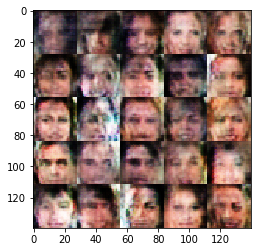

Epoch 1/1.... Batch 1710... Discriminator Loss: 1.2058.... Generator Loss: 1.1380
Epoch 1/1.... Batch 1720... Discriminator Loss: 1.2775.... Generator Loss: 1.0141
Epoch 1/1.... Batch 1730... Discriminator Loss: 0.9297.... Generator Loss: 2.2164
Epoch 1/1.... Batch 1740... Discriminator Loss: 1.2261.... Generator Loss: 0.8872
Epoch 1/1.... Batch 1750... Discriminator Loss: 1.1138.... Generator Loss: 0.8891
Epoch 1/1.... Batch 1760... Discriminator Loss: 1.8384.... Generator Loss: 1.6736
Epoch 1/1.... Batch 1770... Discriminator Loss: 1.6603.... Generator Loss: 2.2423
Epoch 1/1.... Batch 1780... Discriminator Loss: 1.2493.... Generator Loss: 0.7323
Epoch 1/1.... Batch 1790... Discriminator Loss: 1.5175.... Generator Loss: 2.8937
Epoch 1/1.... Batch 1800... Discriminator Loss: 0.9986.... Generator Loss: 1.3239


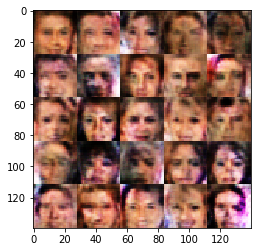

Epoch 1/1.... Batch 1810... Discriminator Loss: 1.0233.... Generator Loss: 1.3216
Epoch 1/1.... Batch 1820... Discriminator Loss: 1.3896.... Generator Loss: 0.7859
Epoch 1/1.... Batch 1830... Discriminator Loss: 1.3199.... Generator Loss: 1.1907
Epoch 1/1.... Batch 1840... Discriminator Loss: 1.3824.... Generator Loss: 1.4348
Epoch 1/1.... Batch 1850... Discriminator Loss: 1.2709.... Generator Loss: 0.9852
Epoch 1/1.... Batch 1860... Discriminator Loss: 1.2449.... Generator Loss: 1.2116
Epoch 1/1.... Batch 1870... Discriminator Loss: 1.2401.... Generator Loss: 1.2804
Epoch 1/1.... Batch 1880... Discriminator Loss: 1.2650.... Generator Loss: 0.9355
Epoch 1/1.... Batch 1890... Discriminator Loss: 1.3675.... Generator Loss: 0.7256
Epoch 1/1.... Batch 1900... Discriminator Loss: 1.2840.... Generator Loss: 1.2599


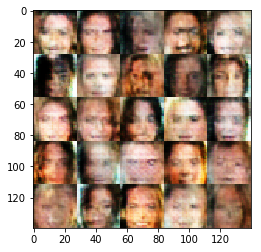

Epoch 1/1.... Batch 1910... Discriminator Loss: 1.7312.... Generator Loss: 0.3999
Epoch 1/1.... Batch 1920... Discriminator Loss: 1.2168.... Generator Loss: 1.1517
Epoch 1/1.... Batch 1930... Discriminator Loss: 1.1592.... Generator Loss: 0.9912
Epoch 1/1.... Batch 1940... Discriminator Loss: 1.4415.... Generator Loss: 0.6424
Epoch 1/1.... Batch 1950... Discriminator Loss: 1.4237.... Generator Loss: 1.5594
Epoch 1/1.... Batch 1960... Discriminator Loss: 1.0615.... Generator Loss: 1.0096
Epoch 1/1.... Batch 1970... Discriminator Loss: 0.8758.... Generator Loss: 1.2488
Epoch 1/1.... Batch 1980... Discriminator Loss: 1.3768.... Generator Loss: 1.9321
Epoch 1/1.... Batch 1990... Discriminator Loss: 1.1836.... Generator Loss: 0.7802
Epoch 1/1.... Batch 2000... Discriminator Loss: 1.8554.... Generator Loss: 0.7920


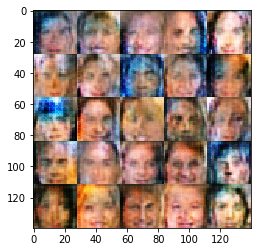

Epoch 1/1.... Batch 2010... Discriminator Loss: 1.0291.... Generator Loss: 1.2231
Epoch 1/1.... Batch 2020... Discriminator Loss: 1.2244.... Generator Loss: 1.0004
Epoch 1/1.... Batch 2030... Discriminator Loss: 1.3171.... Generator Loss: 0.8448
Epoch 1/1.... Batch 2040... Discriminator Loss: 1.2462.... Generator Loss: 1.3837
Epoch 1/1.... Batch 2050... Discriminator Loss: 1.2796.... Generator Loss: 0.9143
Epoch 1/1.... Batch 2060... Discriminator Loss: 1.2409.... Generator Loss: 1.3113
Epoch 1/1.... Batch 2070... Discriminator Loss: 1.2373.... Generator Loss: 0.9003
Epoch 1/1.... Batch 2080... Discriminator Loss: 0.8292.... Generator Loss: 1.6532
Epoch 1/1.... Batch 2090... Discriminator Loss: 0.9918.... Generator Loss: 2.3610
Epoch 1/1.... Batch 2100... Discriminator Loss: 1.3417.... Generator Loss: 0.8423


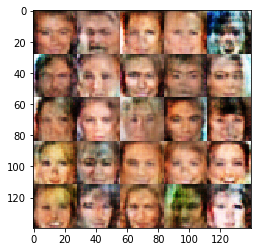

Epoch 1/1.... Batch 2110... Discriminator Loss: 1.2157.... Generator Loss: 1.1279
Epoch 1/1.... Batch 2120... Discriminator Loss: 1.2194.... Generator Loss: 0.8497
Epoch 1/1.... Batch 2130... Discriminator Loss: 1.1901.... Generator Loss: 1.2950
Epoch 1/1.... Batch 2140... Discriminator Loss: 1.1143.... Generator Loss: 1.0132
Epoch 1/1.... Batch 2150... Discriminator Loss: 1.3962.... Generator Loss: 0.8065
Epoch 1/1.... Batch 2160... Discriminator Loss: 1.2501.... Generator Loss: 1.2597
Epoch 1/1.... Batch 2170... Discriminator Loss: 1.1479.... Generator Loss: 1.0886
Epoch 1/1.... Batch 2180... Discriminator Loss: 1.2714.... Generator Loss: 0.9423
Epoch 1/1.... Batch 2190... Discriminator Loss: 1.3663.... Generator Loss: 0.6807
Epoch 1/1.... Batch 2200... Discriminator Loss: 1.3175.... Generator Loss: 0.6788


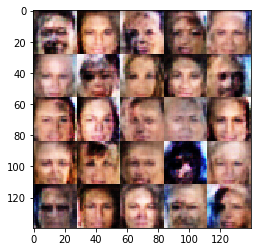

Epoch 1/1.... Batch 2210... Discriminator Loss: 1.2766.... Generator Loss: 1.3381
Epoch 1/1.... Batch 2220... Discriminator Loss: 1.3052.... Generator Loss: 0.7668
Epoch 1/1.... Batch 2230... Discriminator Loss: 1.2673.... Generator Loss: 1.5349
Epoch 1/1.... Batch 2240... Discriminator Loss: 1.2629.... Generator Loss: 1.7220
Epoch 1/1.... Batch 2250... Discriminator Loss: 1.2191.... Generator Loss: 1.1959
Epoch 1/1.... Batch 2260... Discriminator Loss: 1.0873.... Generator Loss: 0.9234
Epoch 1/1.... Batch 2270... Discriminator Loss: 0.7702.... Generator Loss: 1.9532
Epoch 1/1.... Batch 2280... Discriminator Loss: 1.3859.... Generator Loss: 0.6824
Epoch 1/1.... Batch 2290... Discriminator Loss: 1.2936.... Generator Loss: 0.7234
Epoch 1/1.... Batch 2300... Discriminator Loss: 1.2664.... Generator Loss: 0.8546


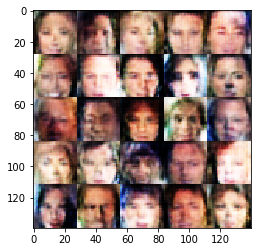

Epoch 1/1.... Batch 2310... Discriminator Loss: 1.2562.... Generator Loss: 0.8183
Epoch 1/1.... Batch 2320... Discriminator Loss: 1.2030.... Generator Loss: 1.2775
Epoch 1/1.... Batch 2330... Discriminator Loss: 1.2788.... Generator Loss: 1.3904
Epoch 1/1.... Batch 2340... Discriminator Loss: 1.2407.... Generator Loss: 0.8319
Epoch 1/1.... Batch 2350... Discriminator Loss: 1.3535.... Generator Loss: 1.1779
Epoch 1/1.... Batch 2360... Discriminator Loss: 1.1124.... Generator Loss: 1.1972
Epoch 1/1.... Batch 2370... Discriminator Loss: 1.1879.... Generator Loss: 1.0960
Epoch 1/1.... Batch 2380... Discriminator Loss: 1.1382.... Generator Loss: 1.0313
Epoch 1/1.... Batch 2390... Discriminator Loss: 1.1622.... Generator Loss: 0.8995
Epoch 1/1.... Batch 2400... Discriminator Loss: 1.1841.... Generator Loss: 1.2135


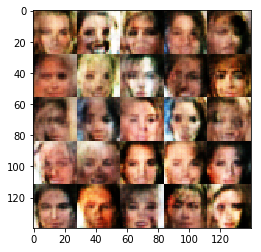

Epoch 1/1.... Batch 2410... Discriminator Loss: 1.3281.... Generator Loss: 0.7717
Epoch 1/1.... Batch 2420... Discriminator Loss: 1.1674.... Generator Loss: 1.6526
Epoch 1/1.... Batch 2430... Discriminator Loss: 0.6603.... Generator Loss: 2.2347
Epoch 1/1.... Batch 2440... Discriminator Loss: 1.4086.... Generator Loss: 0.6831
Epoch 1/1.... Batch 2450... Discriminator Loss: 1.1188.... Generator Loss: 1.0607
Epoch 1/1.... Batch 2460... Discriminator Loss: 1.0238.... Generator Loss: 1.0951
Epoch 1/1.... Batch 2470... Discriminator Loss: 1.2145.... Generator Loss: 0.9153
Epoch 1/1.... Batch 2480... Discriminator Loss: 1.1887.... Generator Loss: 1.0048
Epoch 1/1.... Batch 2490... Discriminator Loss: 1.4159.... Generator Loss: 0.7584
Epoch 1/1.... Batch 2500... Discriminator Loss: 1.3075.... Generator Loss: 1.0334


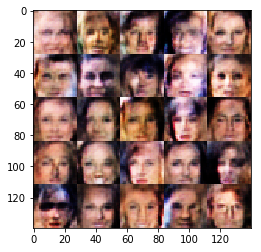

Epoch 1/1.... Batch 2510... Discriminator Loss: 1.1705.... Generator Loss: 1.0486
Epoch 1/1.... Batch 2520... Discriminator Loss: 1.4498.... Generator Loss: 0.7224
Epoch 1/1.... Batch 2530... Discriminator Loss: 1.2037.... Generator Loss: 0.8602
Epoch 1/1.... Batch 2540... Discriminator Loss: 1.2461.... Generator Loss: 0.8678
Epoch 1/1.... Batch 2550... Discriminator Loss: 1.1801.... Generator Loss: 1.0657
Epoch 1/1.... Batch 2560... Discriminator Loss: 1.2963.... Generator Loss: 0.7405
Epoch 1/1.... Batch 2570... Discriminator Loss: 1.3000.... Generator Loss: 0.9755
Epoch 1/1.... Batch 2580... Discriminator Loss: 1.6830.... Generator Loss: 0.4153
Epoch 1/1.... Batch 2590... Discriminator Loss: 1.2134.... Generator Loss: 1.1525
Epoch 1/1.... Batch 2600... Discriminator Loss: 1.1526.... Generator Loss: 1.3653


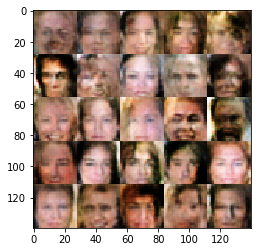

Epoch 1/1.... Batch 2610... Discriminator Loss: 1.4899.... Generator Loss: 0.5301
Epoch 1/1.... Batch 2620... Discriminator Loss: 1.5171.... Generator Loss: 0.5357
Epoch 1/1.... Batch 2630... Discriminator Loss: 1.4422.... Generator Loss: 0.5985
Epoch 1/1.... Batch 2640... Discriminator Loss: 1.1084.... Generator Loss: 1.1431
Epoch 1/1.... Batch 2650... Discriminator Loss: 1.2523.... Generator Loss: 1.0416
Epoch 1/1.... Batch 2660... Discriminator Loss: 1.1231.... Generator Loss: 0.9581
Epoch 1/1.... Batch 2670... Discriminator Loss: 1.4713.... Generator Loss: 0.6459
Epoch 1/1.... Batch 2680... Discriminator Loss: 0.6007.... Generator Loss: 2.7593
Epoch 1/1.... Batch 2690... Discriminator Loss: 0.6004.... Generator Loss: 2.8280
Epoch 1/1.... Batch 2700... Discriminator Loss: 0.9670.... Generator Loss: 1.4442


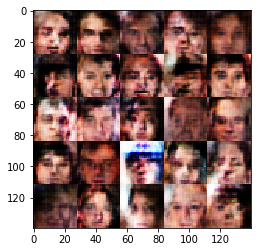

Epoch 1/1.... Batch 2710... Discriminator Loss: 1.4675.... Generator Loss: 1.3261
Epoch 1/1.... Batch 2720... Discriminator Loss: 1.2266.... Generator Loss: 1.4340
Epoch 1/1.... Batch 2730... Discriminator Loss: 0.9274.... Generator Loss: 1.4019
Epoch 1/1.... Batch 2740... Discriminator Loss: 1.0184.... Generator Loss: 1.2101
Epoch 1/1.... Batch 2750... Discriminator Loss: 1.3025.... Generator Loss: 1.1092
Epoch 1/1.... Batch 2760... Discriminator Loss: 1.3005.... Generator Loss: 0.9759
Epoch 1/1.... Batch 2770... Discriminator Loss: 1.1953.... Generator Loss: 1.1801
Epoch 1/1.... Batch 2780... Discriminator Loss: 1.2967.... Generator Loss: 0.9549
Epoch 1/1.... Batch 2790... Discriminator Loss: 1.3256.... Generator Loss: 0.8286
Epoch 1/1.... Batch 2800... Discriminator Loss: 1.3245.... Generator Loss: 0.7845


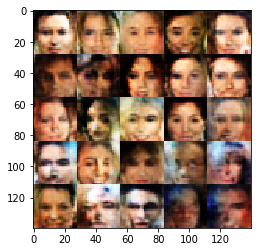

Epoch 1/1.... Batch 2810... Discriminator Loss: 1.2882.... Generator Loss: 1.0129
Epoch 1/1.... Batch 2820... Discriminator Loss: 1.3399.... Generator Loss: 0.8295
Epoch 1/1.... Batch 2830... Discriminator Loss: 1.1968.... Generator Loss: 1.0269
Epoch 1/1.... Batch 2840... Discriminator Loss: 1.3042.... Generator Loss: 1.1874
Epoch 1/1.... Batch 2850... Discriminator Loss: 1.2606.... Generator Loss: 0.8643
Epoch 1/1.... Batch 2860... Discriminator Loss: 1.3554.... Generator Loss: 1.5268
Epoch 1/1.... Batch 2870... Discriminator Loss: 1.2613.... Generator Loss: 0.7348
Epoch 1/1.... Batch 2880... Discriminator Loss: 1.2257.... Generator Loss: 1.0319
Epoch 1/1.... Batch 2890... Discriminator Loss: 1.2926.... Generator Loss: 1.0959
Epoch 1/1.... Batch 2900... Discriminator Loss: 1.1962.... Generator Loss: 0.8810


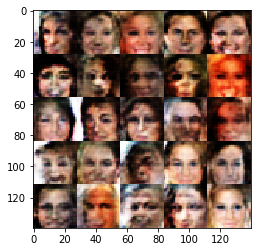

Epoch 1/1.... Batch 2910... Discriminator Loss: 1.1063.... Generator Loss: 1.0833
Epoch 1/1.... Batch 2920... Discriminator Loss: 1.2295.... Generator Loss: 0.8807
Epoch 1/1.... Batch 2930... Discriminator Loss: 1.1875.... Generator Loss: 1.1633
Epoch 1/1.... Batch 2940... Discriminator Loss: 1.1433.... Generator Loss: 1.0487
Epoch 1/1.... Batch 2950... Discriminator Loss: 1.1843.... Generator Loss: 1.0623
Epoch 1/1.... Batch 2960... Discriminator Loss: 1.2268.... Generator Loss: 0.9788
Epoch 1/1.... Batch 2970... Discriminator Loss: 1.2396.... Generator Loss: 1.0387
Epoch 1/1.... Batch 2980... Discriminator Loss: 1.4718.... Generator Loss: 0.5631
Epoch 1/1.... Batch 2990... Discriminator Loss: 1.0065.... Generator Loss: 1.4151
Epoch 1/1.... Batch 3000... Discriminator Loss: 1.3714.... Generator Loss: 0.6731


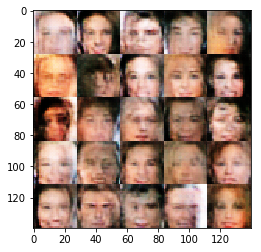

Epoch 1/1.... Batch 3010... Discriminator Loss: 1.3205.... Generator Loss: 0.8775
Epoch 1/1.... Batch 3020... Discriminator Loss: 1.1444.... Generator Loss: 1.1647
Epoch 1/1.... Batch 3030... Discriminator Loss: 1.2156.... Generator Loss: 1.1277
Epoch 1/1.... Batch 3040... Discriminator Loss: 1.2363.... Generator Loss: 0.9707
Epoch 1/1.... Batch 3050... Discriminator Loss: 1.2696.... Generator Loss: 0.9039
Epoch 1/1.... Batch 3060... Discriminator Loss: 1.2428.... Generator Loss: 1.0075
Epoch 1/1.... Batch 3070... Discriminator Loss: 1.2069.... Generator Loss: 0.9652
Epoch 1/1.... Batch 3080... Discriminator Loss: 1.0067.... Generator Loss: 1.1889
Epoch 1/1.... Batch 3090... Discriminator Loss: 1.1868.... Generator Loss: 1.0392
Epoch 1/1.... Batch 3100... Discriminator Loss: 1.3819.... Generator Loss: 0.7506


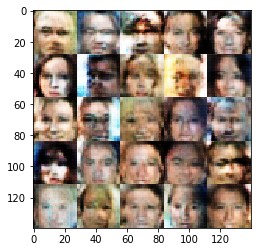

Epoch 1/1.... Batch 3110... Discriminator Loss: 1.1605.... Generator Loss: 0.9466
Epoch 1/1.... Batch 3120... Discriminator Loss: 1.2896.... Generator Loss: 0.8033
Epoch 1/1.... Batch 3130... Discriminator Loss: 1.1782.... Generator Loss: 0.9299
Epoch 1/1.... Batch 3140... Discriminator Loss: 1.2537.... Generator Loss: 0.8878
Epoch 1/1.... Batch 3150... Discriminator Loss: 1.6551.... Generator Loss: 1.8585
Epoch 1/1.... Batch 3160... Discriminator Loss: 1.2623.... Generator Loss: 0.9244
Epoch 1/1.... Batch 3170... Discriminator Loss: 1.1264.... Generator Loss: 1.0514
Epoch 1/1.... Batch 3180... Discriminator Loss: 1.3817.... Generator Loss: 0.7768
Epoch 1/1.... Batch 3190... Discriminator Loss: 1.2324.... Generator Loss: 0.9941
Epoch 1/1.... Batch 3200... Discriminator Loss: 2.4155.... Generator Loss: 3.5281


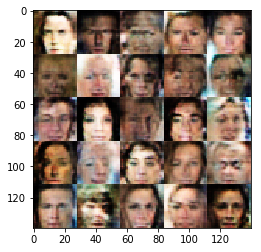

Epoch 1/1.... Batch 3210... Discriminator Loss: 1.2937.... Generator Loss: 0.9844
Epoch 1/1.... Batch 3220... Discriminator Loss: 1.2558.... Generator Loss: 0.9780
Epoch 1/1.... Batch 3230... Discriminator Loss: 1.0937.... Generator Loss: 1.1487
Epoch 1/1.... Batch 3240... Discriminator Loss: 1.3287.... Generator Loss: 0.8357
Epoch 1/1.... Batch 3250... Discriminator Loss: 1.2148.... Generator Loss: 1.0083
Epoch 1/1.... Batch 3260... Discriminator Loss: 1.2058.... Generator Loss: 1.1077
Epoch 1/1.... Batch 3270... Discriminator Loss: 1.2747.... Generator Loss: 0.9459
Epoch 1/1.... Batch 3280... Discriminator Loss: 1.5986.... Generator Loss: 2.1716
Epoch 1/1.... Batch 3290... Discriminator Loss: 1.0640.... Generator Loss: 1.3812
Epoch 1/1.... Batch 3300... Discriminator Loss: 2.2400.... Generator Loss: 0.3303


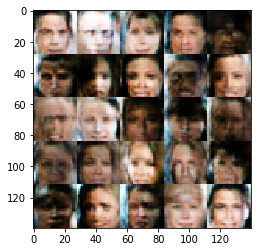

Epoch 1/1.... Batch 3310... Discriminator Loss: 1.1863.... Generator Loss: 1.2055
Epoch 1/1.... Batch 3320... Discriminator Loss: 1.3607.... Generator Loss: 0.6597
Epoch 1/1.... Batch 3330... Discriminator Loss: 1.1739.... Generator Loss: 1.1018
Epoch 1/1.... Batch 3340... Discriminator Loss: 1.3041.... Generator Loss: 0.7411
Epoch 1/1.... Batch 3350... Discriminator Loss: 1.1698.... Generator Loss: 0.9453
Epoch 1/1.... Batch 3360... Discriminator Loss: 1.0433.... Generator Loss: 1.1377
Epoch 1/1.... Batch 3370... Discriminator Loss: 0.9389.... Generator Loss: 2.5820
Epoch 1/1.... Batch 3380... Discriminator Loss: 0.8352.... Generator Loss: 1.4397
Epoch 1/1.... Batch 3390... Discriminator Loss: 1.6942.... Generator Loss: 0.4180
Epoch 1/1.... Batch 3400... Discriminator Loss: 1.1883.... Generator Loss: 1.0420


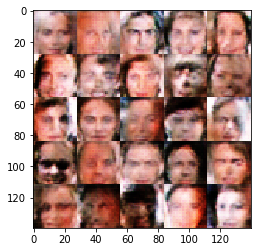

Epoch 1/1.... Batch 3410... Discriminator Loss: 1.2116.... Generator Loss: 1.0408
Epoch 1/1.... Batch 3420... Discriminator Loss: 1.2537.... Generator Loss: 1.1175
Epoch 1/1.... Batch 3430... Discriminator Loss: 1.1250.... Generator Loss: 1.1940
Epoch 1/1.... Batch 3440... Discriminator Loss: 1.2024.... Generator Loss: 0.9226
Epoch 1/1.... Batch 3450... Discriminator Loss: 1.2335.... Generator Loss: 0.8260
Epoch 1/1.... Batch 3460... Discriminator Loss: 1.3328.... Generator Loss: 0.7963
Epoch 1/1.... Batch 3470... Discriminator Loss: 1.3221.... Generator Loss: 0.7749
Epoch 1/1.... Batch 3480... Discriminator Loss: 1.1818.... Generator Loss: 0.8434
Epoch 1/1.... Batch 3490... Discriminator Loss: 1.2236.... Generator Loss: 1.5611
Epoch 1/1.... Batch 3500... Discriminator Loss: 1.3189.... Generator Loss: 0.8235


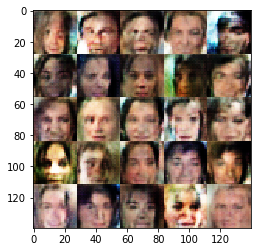

Epoch 1/1.... Batch 3510... Discriminator Loss: 1.2096.... Generator Loss: 1.2872
Epoch 1/1.... Batch 3520... Discriminator Loss: 1.1458.... Generator Loss: 1.1270
Epoch 1/1.... Batch 3530... Discriminator Loss: 1.1997.... Generator Loss: 0.9127
Epoch 1/1.... Batch 3540... Discriminator Loss: 1.2014.... Generator Loss: 0.9055
Epoch 1/1.... Batch 3550... Discriminator Loss: 1.3465.... Generator Loss: 0.8725
Epoch 1/1.... Batch 3560... Discriminator Loss: 1.1158.... Generator Loss: 1.0915
Epoch 1/1.... Batch 3570... Discriminator Loss: 1.2570.... Generator Loss: 0.9756
Epoch 1/1.... Batch 3580... Discriminator Loss: 1.2328.... Generator Loss: 0.8627
Epoch 1/1.... Batch 3590... Discriminator Loss: 1.2124.... Generator Loss: 1.4995
Epoch 1/1.... Batch 3600... Discriminator Loss: 1.4194.... Generator Loss: 0.6397


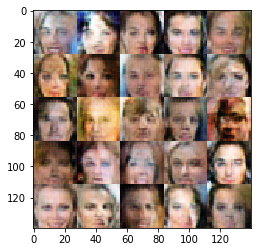

Epoch 1/1.... Batch 3610... Discriminator Loss: 0.8316.... Generator Loss: 1.8647
Epoch 1/1.... Batch 3620... Discriminator Loss: 1.1205.... Generator Loss: 2.0205
Epoch 1/1.... Batch 3630... Discriminator Loss: 0.8951.... Generator Loss: 1.7191
Epoch 1/1.... Batch 3640... Discriminator Loss: 0.9961.... Generator Loss: 1.4452
Epoch 1/1.... Batch 3650... Discriminator Loss: 1.1445.... Generator Loss: 0.9311
Epoch 1/1.... Batch 3660... Discriminator Loss: 1.3132.... Generator Loss: 1.4348
Epoch 1/1.... Batch 3670... Discriminator Loss: 1.2886.... Generator Loss: 1.1121
Epoch 1/1.... Batch 3680... Discriminator Loss: 1.3053.... Generator Loss: 0.7258
Epoch 1/1.... Batch 3690... Discriminator Loss: 1.3286.... Generator Loss: 1.1433
Epoch 1/1.... Batch 3700... Discriminator Loss: 1.1998.... Generator Loss: 0.9327


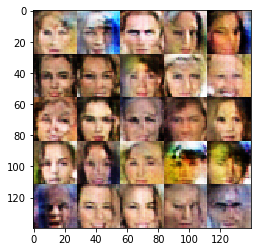

Epoch 1/1.... Batch 3710... Discriminator Loss: 1.1175.... Generator Loss: 1.0301
Epoch 1/1.... Batch 3720... Discriminator Loss: 1.6078.... Generator Loss: 1.7219
Epoch 1/1.... Batch 3730... Discriminator Loss: 1.2362.... Generator Loss: 1.2397
Epoch 1/1.... Batch 3740... Discriminator Loss: 1.3029.... Generator Loss: 0.7128
Epoch 1/1.... Batch 3750... Discriminator Loss: 1.3156.... Generator Loss: 0.7834
Epoch 1/1.... Batch 3760... Discriminator Loss: 1.2084.... Generator Loss: 0.9995
Epoch 1/1.... Batch 3770... Discriminator Loss: 1.2622.... Generator Loss: 0.9236
Epoch 1/1.... Batch 3780... Discriminator Loss: 1.1780.... Generator Loss: 0.9812
Epoch 1/1.... Batch 3790... Discriminator Loss: 2.4438.... Generator Loss: 3.4441
Epoch 1/1.... Batch 3800... Discriminator Loss: 1.3592.... Generator Loss: 1.1201


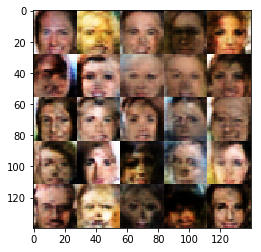

Epoch 1/1.... Batch 3810... Discriminator Loss: 1.2668.... Generator Loss: 0.9392
Epoch 1/1.... Batch 3820... Discriminator Loss: 1.1699.... Generator Loss: 1.1356
Epoch 1/1.... Batch 3830... Discriminator Loss: 1.2998.... Generator Loss: 0.8986
Epoch 1/1.... Batch 3840... Discriminator Loss: 1.1447.... Generator Loss: 1.0085
Epoch 1/1.... Batch 3850... Discriminator Loss: 1.2574.... Generator Loss: 0.9338
Epoch 1/1.... Batch 3860... Discriminator Loss: 1.2612.... Generator Loss: 1.1155
Epoch 1/1.... Batch 3870... Discriminator Loss: 1.2988.... Generator Loss: 1.3329
Epoch 1/1.... Batch 3880... Discriminator Loss: 1.0953.... Generator Loss: 1.1606
Epoch 1/1.... Batch 3890... Discriminator Loss: 1.3431.... Generator Loss: 0.7505
Epoch 1/1.... Batch 3900... Discriminator Loss: 1.2176.... Generator Loss: 1.0753


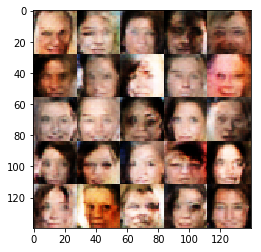

Epoch 1/1.... Batch 3910... Discriminator Loss: 1.2783.... Generator Loss: 0.8066
Epoch 1/1.... Batch 3920... Discriminator Loss: 1.1923.... Generator Loss: 1.0346
Epoch 1/1.... Batch 3930... Discriminator Loss: 1.4324.... Generator Loss: 0.8671
Epoch 1/1.... Batch 3940... Discriminator Loss: 1.2272.... Generator Loss: 1.3621
Epoch 1/1.... Batch 3950... Discriminator Loss: 1.3810.... Generator Loss: 1.2477
Epoch 1/1.... Batch 3960... Discriminator Loss: 1.1509.... Generator Loss: 1.1477
Epoch 1/1.... Batch 3970... Discriminator Loss: 1.2977.... Generator Loss: 0.8592
Epoch 1/1.... Batch 3980... Discriminator Loss: 1.2420.... Generator Loss: 1.5730
Epoch 1/1.... Batch 3990... Discriminator Loss: 1.3316.... Generator Loss: 0.7980
Epoch 1/1.... Batch 4000... Discriminator Loss: 1.3046.... Generator Loss: 0.7445


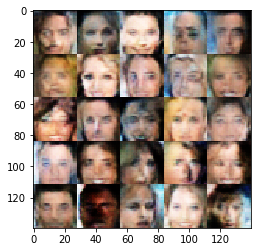

Epoch 1/1.... Batch 4010... Discriminator Loss: 0.7876.... Generator Loss: 1.6843
Epoch 1/1.... Batch 4020... Discriminator Loss: 1.2246.... Generator Loss: 1.2859
Epoch 1/1.... Batch 4030... Discriminator Loss: 1.1010.... Generator Loss: 1.3585
Epoch 1/1.... Batch 4040... Discriminator Loss: 1.3727.... Generator Loss: 0.7127
Epoch 1/1.... Batch 4050... Discriminator Loss: 1.1869.... Generator Loss: 1.2681
Epoch 1/1.... Batch 4060... Discriminator Loss: 1.2970.... Generator Loss: 0.8374
Epoch 1/1.... Batch 4070... Discriminator Loss: 1.1495.... Generator Loss: 1.0380
Epoch 1/1.... Batch 4080... Discriminator Loss: 1.2322.... Generator Loss: 1.2889
Epoch 1/1.... Batch 4090... Discriminator Loss: 1.2083.... Generator Loss: 1.0075
Epoch 1/1.... Batch 4100... Discriminator Loss: 1.1206.... Generator Loss: 1.3522


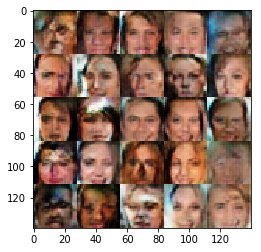

Epoch 1/1.... Batch 4110... Discriminator Loss: 1.2331.... Generator Loss: 1.2889
Epoch 1/1.... Batch 4120... Discriminator Loss: 1.3031.... Generator Loss: 0.6821
Epoch 1/1.... Batch 4130... Discriminator Loss: 0.9784.... Generator Loss: 1.6510
Epoch 1/1.... Batch 4140... Discriminator Loss: 1.2576.... Generator Loss: 0.7388
Epoch 1/1.... Batch 4150... Discriminator Loss: 1.2669.... Generator Loss: 0.8366
Epoch 1/1.... Batch 4160... Discriminator Loss: 1.3132.... Generator Loss: 0.7321
Epoch 1/1.... Batch 4170... Discriminator Loss: 1.2663.... Generator Loss: 0.7854
Epoch 1/1.... Batch 4180... Discriminator Loss: 1.2372.... Generator Loss: 1.6421
Epoch 1/1.... Batch 4190... Discriminator Loss: 1.1935.... Generator Loss: 0.9858
Epoch 1/1.... Batch 4200... Discriminator Loss: 1.4106.... Generator Loss: 0.6434


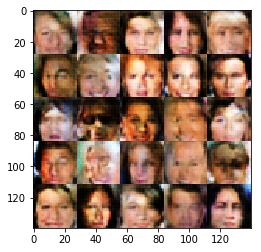

Epoch 1/1.... Batch 4210... Discriminator Loss: 0.9852.... Generator Loss: 1.5630
Epoch 1/1.... Batch 4220... Discriminator Loss: 1.0887.... Generator Loss: 1.2554
Epoch 1/1.... Batch 4230... Discriminator Loss: 0.9381.... Generator Loss: 1.2094
Epoch 1/1.... Batch 4240... Discriminator Loss: 1.2718.... Generator Loss: 1.1499
Epoch 1/1.... Batch 4250... Discriminator Loss: 1.2551.... Generator Loss: 0.9420
Epoch 1/1.... Batch 4260... Discriminator Loss: 1.1904.... Generator Loss: 1.0153
Epoch 1/1.... Batch 4270... Discriminator Loss: 0.8501.... Generator Loss: 1.4236
Epoch 1/1.... Batch 4280... Discriminator Loss: 1.6361.... Generator Loss: 0.4406
Epoch 1/1.... Batch 4290... Discriminator Loss: 1.1405.... Generator Loss: 1.0952
Epoch 1/1.... Batch 4300... Discriminator Loss: 1.1539.... Generator Loss: 1.1262


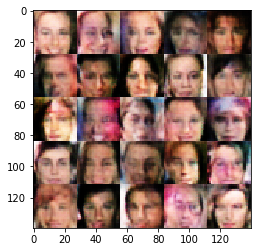

Epoch 1/1.... Batch 4310... Discriminator Loss: 1.1967.... Generator Loss: 1.0512
Epoch 1/1.... Batch 4320... Discriminator Loss: 1.3499.... Generator Loss: 0.8643
Epoch 1/1.... Batch 4330... Discriminator Loss: 1.2460.... Generator Loss: 1.2040
Epoch 1/1.... Batch 4340... Discriminator Loss: 1.1681.... Generator Loss: 1.3048
Epoch 1/1.... Batch 4350... Discriminator Loss: 1.3269.... Generator Loss: 0.8014
Epoch 1/1.... Batch 4360... Discriminator Loss: 1.1044.... Generator Loss: 1.0789
Epoch 1/1.... Batch 4370... Discriminator Loss: 1.6949.... Generator Loss: 0.4392
Epoch 1/1.... Batch 4380... Discriminator Loss: 1.2082.... Generator Loss: 0.8961
Epoch 1/1.... Batch 4390... Discriminator Loss: 1.1195.... Generator Loss: 0.9330
Epoch 1/1.... Batch 4400... Discriminator Loss: 1.1645.... Generator Loss: 1.4127


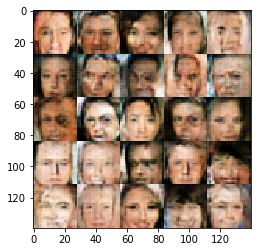

Epoch 1/1.... Batch 4410... Discriminator Loss: 1.2516.... Generator Loss: 1.0040
Epoch 1/1.... Batch 4420... Discriminator Loss: 1.2114.... Generator Loss: 1.0955
Epoch 1/1.... Batch 4430... Discriminator Loss: 1.3527.... Generator Loss: 0.6443
Epoch 1/1.... Batch 4440... Discriminator Loss: 1.2576.... Generator Loss: 1.1541
Epoch 1/1.... Batch 4450... Discriminator Loss: 1.9970.... Generator Loss: 2.3766
Epoch 1/1.... Batch 4460... Discriminator Loss: 1.1940.... Generator Loss: 1.0446
Epoch 1/1.... Batch 4470... Discriminator Loss: 1.2237.... Generator Loss: 0.9429
Epoch 1/1.... Batch 4480... Discriminator Loss: 1.6216.... Generator Loss: 0.5172
Epoch 1/1.... Batch 4490... Discriminator Loss: 1.1864.... Generator Loss: 1.1943
Epoch 1/1.... Batch 4500... Discriminator Loss: 1.5410.... Generator Loss: 2.4108


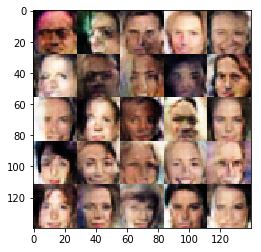

Epoch 1/1.... Batch 4510... Discriminator Loss: 1.2457.... Generator Loss: 1.3333
Epoch 1/1.... Batch 4520... Discriminator Loss: 1.3243.... Generator Loss: 1.0413
Epoch 1/1.... Batch 4530... Discriminator Loss: 1.5206.... Generator Loss: 2.2013
Epoch 1/1.... Batch 4540... Discriminator Loss: 1.2039.... Generator Loss: 1.2147
Epoch 1/1.... Batch 4550... Discriminator Loss: 0.7630.... Generator Loss: 1.8452
Epoch 1/1.... Batch 4560... Discriminator Loss: 1.4411.... Generator Loss: 0.8707
Epoch 1/1.... Batch 4570... Discriminator Loss: 1.3854.... Generator Loss: 0.9353
Epoch 1/1.... Batch 4580... Discriminator Loss: 1.2304.... Generator Loss: 0.9407
Epoch 1/1.... Batch 4590... Discriminator Loss: 1.2131.... Generator Loss: 0.9948
Epoch 1/1.... Batch 4600... Discriminator Loss: 1.1591.... Generator Loss: 1.0858


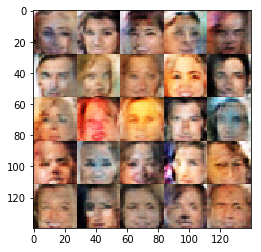

Epoch 1/1.... Batch 4610... Discriminator Loss: 1.2160.... Generator Loss: 0.9783
Epoch 1/1.... Batch 4620... Discriminator Loss: 1.2526.... Generator Loss: 0.8850
Epoch 1/1.... Batch 4630... Discriminator Loss: 1.2594.... Generator Loss: 0.8322
Epoch 1/1.... Batch 4640... Discriminator Loss: 1.3204.... Generator Loss: 0.8671
Epoch 1/1.... Batch 4650... Discriminator Loss: 1.1503.... Generator Loss: 0.8940
Epoch 1/1.... Batch 4660... Discriminator Loss: 1.7413.... Generator Loss: 0.4088
Epoch 1/1.... Batch 4670... Discriminator Loss: 1.2517.... Generator Loss: 0.8807
Epoch 1/1.... Batch 4680... Discriminator Loss: 1.3597.... Generator Loss: 1.0072
Epoch 1/1.... Batch 4690... Discriminator Loss: 1.4309.... Generator Loss: 0.7112
Epoch 1/1.... Batch 4700... Discriminator Loss: 1.6928.... Generator Loss: 0.8689


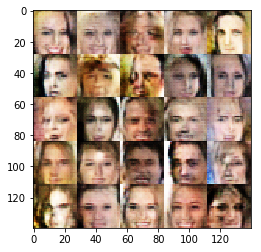

Epoch 1/1.... Batch 4710... Discriminator Loss: 1.2782.... Generator Loss: 1.0054
Epoch 1/1.... Batch 4720... Discriminator Loss: 0.9063.... Generator Loss: 1.2620
Epoch 1/1.... Batch 4730... Discriminator Loss: 1.5308.... Generator Loss: 0.5338
Epoch 1/1.... Batch 4740... Discriminator Loss: 1.1368.... Generator Loss: 1.2174
Epoch 1/1.... Batch 4750... Discriminator Loss: 1.1675.... Generator Loss: 1.0283
Epoch 1/1.... Batch 4760... Discriminator Loss: 0.8356.... Generator Loss: 1.4960
Epoch 1/1.... Batch 4770... Discriminator Loss: 0.8082.... Generator Loss: 1.4327
Epoch 1/1.... Batch 4780... Discriminator Loss: 2.1568.... Generator Loss: 2.1688
Epoch 1/1.... Batch 4790... Discriminator Loss: 1.0344.... Generator Loss: 0.9939
Epoch 1/1.... Batch 4800... Discriminator Loss: 1.0813.... Generator Loss: 1.1955


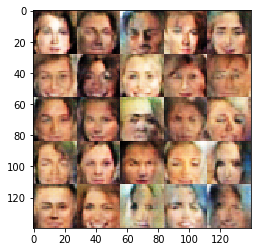

Epoch 1/1.... Batch 4810... Discriminator Loss: 0.8259.... Generator Loss: 1.9913
Epoch 1/1.... Batch 4820... Discriminator Loss: 1.7272.... Generator Loss: 0.4193
Epoch 1/1.... Batch 4830... Discriminator Loss: 1.0828.... Generator Loss: 1.0372
Epoch 1/1.... Batch 4840... Discriminator Loss: 1.2641.... Generator Loss: 0.9231
Epoch 1/1.... Batch 4850... Discriminator Loss: 1.2329.... Generator Loss: 1.1904
Epoch 1/1.... Batch 4860... Discriminator Loss: 1.2806.... Generator Loss: 0.8027
Epoch 1/1.... Batch 4870... Discriminator Loss: 1.2508.... Generator Loss: 0.9707
Epoch 1/1.... Batch 4880... Discriminator Loss: 1.1238.... Generator Loss: 1.3973
Epoch 1/1.... Batch 4890... Discriminator Loss: 1.2497.... Generator Loss: 1.1436
Epoch 1/1.... Batch 4900... Discriminator Loss: 1.2854.... Generator Loss: 0.9200


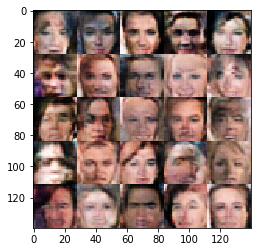

Epoch 1/1.... Batch 4910... Discriminator Loss: 0.9413.... Generator Loss: 1.2734
Epoch 1/1.... Batch 4920... Discriminator Loss: 1.2947.... Generator Loss: 0.7472
Epoch 1/1.... Batch 4930... Discriminator Loss: 2.5837.... Generator Loss: 3.8811
Epoch 1/1.... Batch 4940... Discriminator Loss: 1.1936.... Generator Loss: 1.1819
Epoch 1/1.... Batch 4950... Discriminator Loss: 1.2288.... Generator Loss: 1.0461
Epoch 1/1.... Batch 4960... Discriminator Loss: 1.2089.... Generator Loss: 0.9724
Epoch 1/1.... Batch 4970... Discriminator Loss: 1.2317.... Generator Loss: 1.0319
Epoch 1/1.... Batch 4980... Discriminator Loss: 1.3307.... Generator Loss: 0.7377
Epoch 1/1.... Batch 4990... Discriminator Loss: 1.3588.... Generator Loss: 1.3778
Epoch 1/1.... Batch 5000... Discriminator Loss: 1.3934.... Generator Loss: 0.6620


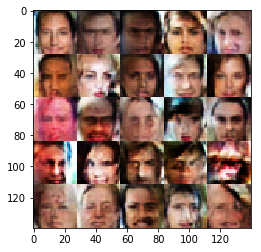

Epoch 1/1.... Batch 5010... Discriminator Loss: 1.2107.... Generator Loss: 1.1665
Epoch 1/1.... Batch 5020... Discriminator Loss: 0.9787.... Generator Loss: 1.3379
Epoch 1/1.... Batch 5030... Discriminator Loss: 2.0671.... Generator Loss: 2.2913
Epoch 1/1.... Batch 5040... Discriminator Loss: 1.0863.... Generator Loss: 1.1386
Epoch 1/1.... Batch 5050... Discriminator Loss: 1.3164.... Generator Loss: 0.8300
Epoch 1/1.... Batch 5060... Discriminator Loss: 1.2293.... Generator Loss: 0.9621
Epoch 1/1.... Batch 5070... Discriminator Loss: 1.4341.... Generator Loss: 0.7639
Epoch 1/1.... Batch 5080... Discriminator Loss: 1.2268.... Generator Loss: 1.0996
Epoch 1/1.... Batch 5090... Discriminator Loss: 1.2924.... Generator Loss: 0.7926
Epoch 1/1.... Batch 5100... Discriminator Loss: 1.2175.... Generator Loss: 1.1767


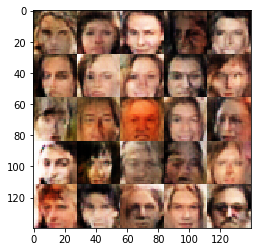

Epoch 1/1.... Batch 5110... Discriminator Loss: 1.3474.... Generator Loss: 0.7993
Epoch 1/1.... Batch 5120... Discriminator Loss: 1.1914.... Generator Loss: 1.0487
Epoch 1/1.... Batch 5130... Discriminator Loss: 1.1065.... Generator Loss: 0.9372
Epoch 1/1.... Batch 5140... Discriminator Loss: 1.2643.... Generator Loss: 0.8108
Epoch 1/1.... Batch 5150... Discriminator Loss: 1.2637.... Generator Loss: 1.1888
Epoch 1/1.... Batch 5160... Discriminator Loss: 1.3290.... Generator Loss: 0.6992
Epoch 1/1.... Batch 5170... Discriminator Loss: 1.0594.... Generator Loss: 1.0265
Epoch 1/1.... Batch 5180... Discriminator Loss: 1.2294.... Generator Loss: 0.9914
Epoch 1/1.... Batch 5190... Discriminator Loss: 1.2642.... Generator Loss: 0.8934
Epoch 1/1.... Batch 5200... Discriminator Loss: 1.2652.... Generator Loss: 0.9300


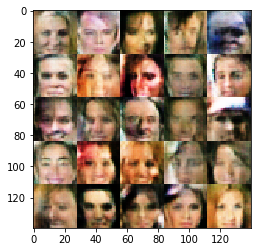

Epoch 1/1.... Batch 5210... Discriminator Loss: 1.2764.... Generator Loss: 0.7519
Epoch 1/1.... Batch 5220... Discriminator Loss: 1.2215.... Generator Loss: 1.2343
Epoch 1/1.... Batch 5230... Discriminator Loss: 1.2284.... Generator Loss: 0.9546
Epoch 1/1.... Batch 5240... Discriminator Loss: 1.2511.... Generator Loss: 0.9461
Epoch 1/1.... Batch 5250... Discriminator Loss: 1.2253.... Generator Loss: 1.1097
Epoch 1/1.... Batch 5260... Discriminator Loss: 1.2341.... Generator Loss: 0.9554
Epoch 1/1.... Batch 5270... Discriminator Loss: 1.2031.... Generator Loss: 1.1749
Epoch 1/1.... Batch 5280... Discriminator Loss: 1.2005.... Generator Loss: 1.0784
Epoch 1/1.... Batch 5290... Discriminator Loss: 1.2803.... Generator Loss: 0.9823
Epoch 1/1.... Batch 5300... Discriminator Loss: 1.1938.... Generator Loss: 1.0491


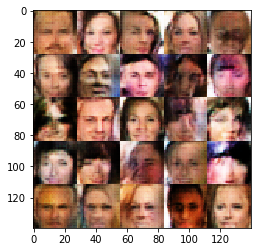

Epoch 1/1.... Batch 5310... Discriminator Loss: 1.3836.... Generator Loss: 0.8639
Epoch 1/1.... Batch 5320... Discriminator Loss: 1.3891.... Generator Loss: 0.7475
Epoch 1/1.... Batch 5330... Discriminator Loss: 1.2159.... Generator Loss: 0.8782
Epoch 1/1.... Batch 5340... Discriminator Loss: 1.1394.... Generator Loss: 1.4012
Epoch 1/1.... Batch 5350... Discriminator Loss: 1.3519.... Generator Loss: 0.6686
Epoch 1/1.... Batch 5360... Discriminator Loss: 1.2202.... Generator Loss: 1.0969
Epoch 1/1.... Batch 5370... Discriminator Loss: 1.5381.... Generator Loss: 0.5184
Epoch 1/1.... Batch 5380... Discriminator Loss: 1.2012.... Generator Loss: 1.1848
Epoch 1/1.... Batch 5390... Discriminator Loss: 1.2178.... Generator Loss: 1.0637
Epoch 1/1.... Batch 5400... Discriminator Loss: 1.2591.... Generator Loss: 0.9944


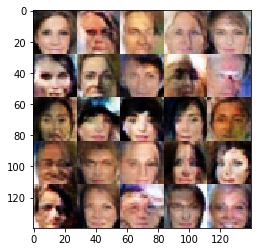

Epoch 1/1.... Batch 5410... Discriminator Loss: 1.1535.... Generator Loss: 1.3074
Epoch 1/1.... Batch 5420... Discriminator Loss: 1.3204.... Generator Loss: 1.3938
Epoch 1/1.... Batch 5430... Discriminator Loss: 1.5343.... Generator Loss: 0.5228
Epoch 1/1.... Batch 5440... Discriminator Loss: 1.3784.... Generator Loss: 0.9315
Epoch 1/1.... Batch 5450... Discriminator Loss: 1.0106.... Generator Loss: 1.3021
Epoch 1/1.... Batch 5460... Discriminator Loss: 1.6387.... Generator Loss: 0.4694
Epoch 1/1.... Batch 5470... Discriminator Loss: 1.3351.... Generator Loss: 0.8861
Epoch 1/1.... Batch 5480... Discriminator Loss: 1.3049.... Generator Loss: 0.7779
Epoch 1/1.... Batch 5490... Discriminator Loss: 1.2971.... Generator Loss: 0.7401
Epoch 1/1.... Batch 5500... Discriminator Loss: 1.2292.... Generator Loss: 0.9779


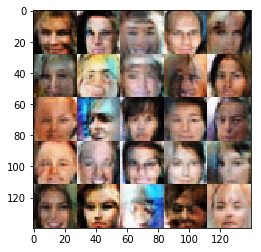

Epoch 1/1.... Batch 5510... Discriminator Loss: 1.2323.... Generator Loss: 0.9462
Epoch 1/1.... Batch 5520... Discriminator Loss: 1.7723.... Generator Loss: 1.8956
Epoch 1/1.... Batch 5530... Discriminator Loss: 1.4171.... Generator Loss: 3.0150
Epoch 1/1.... Batch 5540... Discriminator Loss: 0.7513.... Generator Loss: 2.5199
Epoch 1/1.... Batch 5550... Discriminator Loss: 1.3341.... Generator Loss: 1.0588
Epoch 1/1.... Batch 5560... Discriminator Loss: 1.2335.... Generator Loss: 1.2035
Epoch 1/1.... Batch 5570... Discriminator Loss: 1.3139.... Generator Loss: 0.7971
Epoch 1/1.... Batch 5580... Discriminator Loss: 1.1854.... Generator Loss: 1.0307
Epoch 1/1.... Batch 5590... Discriminator Loss: 1.2141.... Generator Loss: 0.8639
Epoch 1/1.... Batch 5600... Discriminator Loss: 1.2276.... Generator Loss: 1.0544


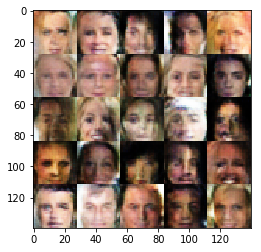

Epoch 1/1.... Batch 5610... Discriminator Loss: 1.2238.... Generator Loss: 0.8778
Epoch 1/1.... Batch 5620... Discriminator Loss: 1.1919.... Generator Loss: 1.1141
Epoch 1/1.... Batch 5630... Discriminator Loss: 1.2538.... Generator Loss: 0.9645
Epoch 1/1.... Batch 5640... Discriminator Loss: 1.1836.... Generator Loss: 1.0737
Epoch 1/1.... Batch 5650... Discriminator Loss: 1.1802.... Generator Loss: 0.9444
Epoch 1/1.... Batch 5660... Discriminator Loss: 1.3301.... Generator Loss: 0.7888
Epoch 1/1.... Batch 5670... Discriminator Loss: 1.3176.... Generator Loss: 0.7855
Epoch 1/1.... Batch 5680... Discriminator Loss: 1.2139.... Generator Loss: 0.9323
Epoch 1/1.... Batch 5690... Discriminator Loss: 1.2613.... Generator Loss: 1.0950
Epoch 1/1.... Batch 5700... Discriminator Loss: 1.2662.... Generator Loss: 0.8163


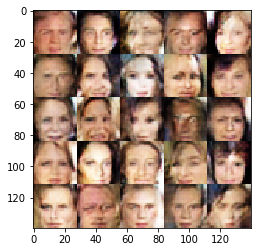

Epoch 1/1.... Batch 5710... Discriminator Loss: 1.3056.... Generator Loss: 1.0483
Epoch 1/1.... Batch 5720... Discriminator Loss: 1.3099.... Generator Loss: 1.0274
Epoch 1/1.... Batch 5730... Discriminator Loss: 1.3291.... Generator Loss: 0.8724
Epoch 1/1.... Batch 5740... Discriminator Loss: 1.1225.... Generator Loss: 1.1964
Epoch 1/1.... Batch 5750... Discriminator Loss: 1.2175.... Generator Loss: 0.9614
Epoch 1/1.... Batch 5760... Discriminator Loss: 1.0805.... Generator Loss: 1.3793
Epoch 1/1.... Batch 5770... Discriminator Loss: 3.4679.... Generator Loss: 4.2173
Epoch 1/1.... Batch 5780... Discriminator Loss: 1.3787.... Generator Loss: 0.8627
Epoch 1/1.... Batch 5790... Discriminator Loss: 1.3354.... Generator Loss: 0.8985
Epoch 1/1.... Batch 5800... Discriminator Loss: 1.4506.... Generator Loss: 0.6449


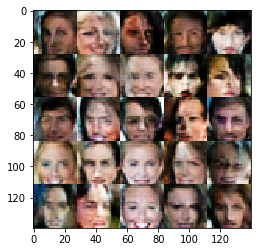

Epoch 1/1.... Batch 5810... Discriminator Loss: 1.3325.... Generator Loss: 0.9208
Epoch 1/1.... Batch 5820... Discriminator Loss: 1.2272.... Generator Loss: 1.2822
Epoch 1/1.... Batch 5830... Discriminator Loss: 1.1547.... Generator Loss: 1.2056
Epoch 1/1.... Batch 5840... Discriminator Loss: 1.2759.... Generator Loss: 0.9475
Epoch 1/1.... Batch 5850... Discriminator Loss: 1.3141.... Generator Loss: 0.8841
Epoch 1/1.... Batch 5860... Discriminator Loss: 1.1947.... Generator Loss: 0.9272
Epoch 1/1.... Batch 5870... Discriminator Loss: 1.3026.... Generator Loss: 0.8664
Epoch 1/1.... Batch 5880... Discriminator Loss: 1.1867.... Generator Loss: 1.0010
Epoch 1/1.... Batch 5890... Discriminator Loss: 1.1700.... Generator Loss: 1.0377
Epoch 1/1.... Batch 5900... Discriminator Loss: 1.3081.... Generator Loss: 0.8243


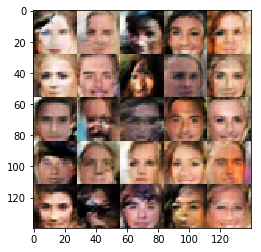

Epoch 1/1.... Batch 5910... Discriminator Loss: 1.2898.... Generator Loss: 1.0205
Epoch 1/1.... Batch 5920... Discriminator Loss: 1.2445.... Generator Loss: 0.9088
Epoch 1/1.... Batch 5930... Discriminator Loss: 1.2542.... Generator Loss: 0.9782
Epoch 1/1.... Batch 5940... Discriminator Loss: 1.2601.... Generator Loss: 0.7524
Epoch 1/1.... Batch 5950... Discriminator Loss: 1.2779.... Generator Loss: 1.0596
Epoch 1/1.... Batch 5960... Discriminator Loss: 1.1766.... Generator Loss: 0.8857
Epoch 1/1.... Batch 5970... Discriminator Loss: 1.3558.... Generator Loss: 0.6742
Epoch 1/1.... Batch 5980... Discriminator Loss: 1.1402.... Generator Loss: 1.2278
Epoch 1/1.... Batch 5990... Discriminator Loss: 1.3020.... Generator Loss: 0.9099
Epoch 1/1.... Batch 6000... Discriminator Loss: 1.4142.... Generator Loss: 1.2091


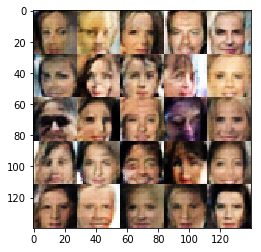

Epoch 1/1.... Batch 6010... Discriminator Loss: 1.3536.... Generator Loss: 0.8146
Epoch 1/1.... Batch 6020... Discriminator Loss: 1.3340.... Generator Loss: 0.8028
Epoch 1/1.... Batch 6030... Discriminator Loss: 1.3429.... Generator Loss: 0.7475
Epoch 1/1.... Batch 6040... Discriminator Loss: 1.2443.... Generator Loss: 1.2401
Epoch 1/1.... Batch 6050... Discriminator Loss: 1.2463.... Generator Loss: 0.9341
Epoch 1/1.... Batch 6060... Discriminator Loss: 1.1605.... Generator Loss: 1.0424
Epoch 1/1.... Batch 6070... Discriminator Loss: 1.3172.... Generator Loss: 0.9344
Epoch 1/1.... Batch 6080... Discriminator Loss: 1.2283.... Generator Loss: 0.8585
Epoch 1/1.... Batch 6090... Discriminator Loss: 1.2422.... Generator Loss: 1.3658
Epoch 1/1.... Batch 6100... Discriminator Loss: 0.9901.... Generator Loss: 1.0773


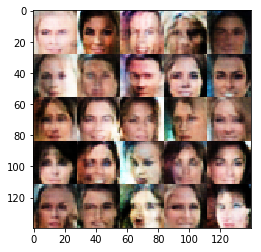

Epoch 1/1.... Batch 6110... Discriminator Loss: 1.3724.... Generator Loss: 0.6714
Epoch 1/1.... Batch 6120... Discriminator Loss: 1.1783.... Generator Loss: 1.0978
Epoch 1/1.... Batch 6130... Discriminator Loss: 1.2453.... Generator Loss: 0.8744
Epoch 1/1.... Batch 6140... Discriminator Loss: 1.2882.... Generator Loss: 1.4622
Epoch 1/1.... Batch 6150... Discriminator Loss: 1.2147.... Generator Loss: 0.8956
Epoch 1/1.... Batch 6160... Discriminator Loss: 1.2032.... Generator Loss: 1.1436
Epoch 1/1.... Batch 6170... Discriminator Loss: 1.2702.... Generator Loss: 0.9326
Epoch 1/1.... Batch 6180... Discriminator Loss: 1.2446.... Generator Loss: 0.8241
Epoch 1/1.... Batch 6190... Discriminator Loss: 1.1440.... Generator Loss: 1.0545
Epoch 1/1.... Batch 6200... Discriminator Loss: 1.0037.... Generator Loss: 2.3156


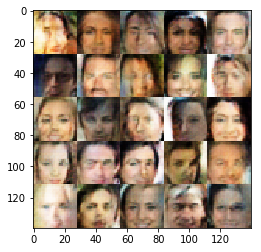

Epoch 1/1.... Batch 6210... Discriminator Loss: 1.2183.... Generator Loss: 1.0736
Epoch 1/1.... Batch 6220... Discriminator Loss: 1.2615.... Generator Loss: 0.9929
Epoch 1/1.... Batch 6230... Discriminator Loss: 1.2917.... Generator Loss: 0.9016
Epoch 1/1.... Batch 6240... Discriminator Loss: 1.1904.... Generator Loss: 1.0323
Epoch 1/1.... Batch 6250... Discriminator Loss: 1.2437.... Generator Loss: 1.0667
Epoch 1/1.... Batch 6260... Discriminator Loss: 1.4054.... Generator Loss: 0.6443
Epoch 1/1.... Batch 6270... Discriminator Loss: 1.1591.... Generator Loss: 1.0450
Epoch 1/1.... Batch 6280... Discriminator Loss: 1.2716.... Generator Loss: 0.9060
Epoch 1/1.... Batch 6290... Discriminator Loss: 1.2283.... Generator Loss: 0.9120
Epoch 1/1.... Batch 6300... Discriminator Loss: 1.3661.... Generator Loss: 1.1418


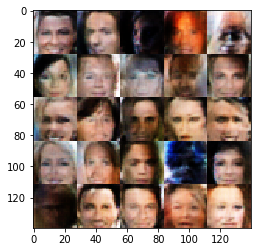

Epoch 1/1.... Batch 6310... Discriminator Loss: 1.2843.... Generator Loss: 0.9602
Epoch 1/1.... Batch 6320... Discriminator Loss: 1.3031.... Generator Loss: 0.8151
Epoch 1/1.... Batch 6330... Discriminator Loss: 1.1118.... Generator Loss: 1.3132


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.